# BNP Fraudsters - EDA

## 1. Introduction

This challenge is a use-case from by BNP Paribas Personal Finance, hosted on the platform [challengedata.ens.fr](https://challengedata.ens.fr/participants/challenges/104/). The dataset is under a [public and permissive license](https://etalab.gouv.fr/licence-ouverte-open-licence/).

See the video (in French) of the presentation of the challenge:

https://www.youtube.com/watch?v=M4G83TQK5cI

The bank offers credit to customers of retailers and web merchants and is exposed to various frauds. 

> The Credit Process Optimization team supports local risk teams to improve credit processes' efficiency, balance profitability, customer journey, and risk profiles.

Although mentioned, the context in which the models are used is not precise enough to derive operational constraints and a precise utility function to optimize. Instead, the challenge suggests maximizing the average precision (i.e. the PR curve AUC). We will stick, however, to a virtual utility function using our best guess.

By its nature, fraud is a very imbalanced classification problem. Here, the prevalence is close to 1.4%. Therefore, we use stratification strategies to avoid selecting too few positive classes in our analysis and modeling.

Finally, the features available are rather limited, e.g. we don't have access to customer data, merchant data, or any temporal information. We only have access to the products in the customer basket (up to 24), with the following attributes for each product:
- item (category of the product)
- make (brand of the product)
- model (the name of the model of the product)
- goods_code (retailer code, we don't have a precise definition of this variable, we assume it is the product reference across different shops)
- Nbr_of_prod_purchas (the number of products selected)
- cash_price (the individual price of a single product)

Since most consumers only select a few different products when applying for a loan, the features are sparse beyond the first two selected products, making fraud detection even more challenging.

## 2. Exploring the variables

The challenge organizers have assembled the data in a single table, which eases our work. Let's load this file:

In [1]:
MAX_ITEMS = 24

def get_group_cols(column, max_items=MAX_ITEMS):
    """Create a list of column names"""
    return [f"{column}{idx}" for idx in range(1, max_items+1)]

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


X = pd.read_csv("X_train.csv", low_memory=False).convert_dtypes()

# Rename the 24 columns 'Nbr_of_prod_purchas' in a shorter 'nbr'
renaming = dict(
    zip(
        get_group_cols("Nbr_of_prod_purchas"),
        get_group_cols("nbr"),
    )
)
X = X.rename(columns=renaming)

# Display the first item attributes
attribute_cols = ["item", "cash_price", "make", "model", "goods_code", "nbr"]
cols = ["ID", *[f"{col}1" for col in attribute_cols], "Nb_of_items"]
X[cols]

ID                             item1  cash_price1        make1  \
0      85517                         COMPUTERS          889        APPLE   
1      51113  COMPUTER PERIPHERALS ACCESSORIES          409        APPLE   
2      83008           TELEVISIONS HOME CINEMA         1399      SAMSUNG   
3      78712                         COMPUTERS          689        APPLE   
4      77846           TELEVISIONS HOME CINEMA         1199         SONY   
...      ...                               ...          ...          ...   
92785  21243  COMPUTER PERIPHERALS ACCESSORIES          299      SAMSUNG   
92786  45891                         COMPUTERS          898        APPLE   
92787  42613                 BEDROOM FURNITURE          519  SILENTNIGHT   
92788  43567                         COMPUTERS         1099        APPLE   
92789  68268           TELEVISIONS HOME CINEMA          799           LG   

                                                  model1 goods_code1  nbr1  \
0      2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...   239246776     1   
1      APPLE WATCH SERIES 6 GPS 44MM SPACE GREY ALUMI...   239001518     1   
2      SAMSUNG QE75Q70A 2021 QLED HDR 4K ULTRA HD SMA...   239842093     1   
3      2020 APPLE IPAD AIR 10 9 A14 BIONIC PROCESSOR IOS   239001422     1   
4      SONY BRAVIA KE48A9 2020 OLED HDR 4K ULTRA HD S...   239952954     1   
...                                                  ...         ...   ...   
92785  SAMSUNG GALAXY WATCH 3 BLUETOOTH 41MM STAINLES...   238905679     1   
92786  2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...   239246776     1   
92787   SILENTNIGHT END DIVAN OTTOMAN STORAGE BED DOUBLE   236938427     1   
92788  2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-F...   240040978     1   
92789  LG OLED48A16LA 2021 OLED HDR 4K ULTRA HD SMART TV   239866717     1   

       Nb_of_items  
0                1  
1                1  
2                1  
3                2  
4                1  
...            ...  
92785            2  
92786            1  
92787            3  
92788            2  
92789            1  

[92790 rows x 8 columns]

We see products like electronics or home furnitures, with a price range close to 1000€. This price range is expected since these buyers used a credit.

We also see that "item" categories have a semantic (and syntaxic) similarity. For instance, "computers" and "computer peripherals accessories" should be closer in some latent feature space than "computers" and "bedroom furniture".

The same observation goes for "model", where models mentioning "MACBOOK" should be closer together. There is somewhat of a redundancy between "model" and "make", since the name of the maker is often included in the model.

"Goods code" is harder to decypher, and may not carry a meaningful encoding. We will explore that later in this analysis.

We can observe that buyers tend to buy only a single of the first, expensive item. This is also expected in a B2C market, where consumers don't stack TVs in their homes.

Note that `Nb_of_items` is the number of **unique** items in the basket, while `nbr{i}` is the **number of instances** of the ith item.

Last but not least, we can intuite that some of our features are hierarchical:

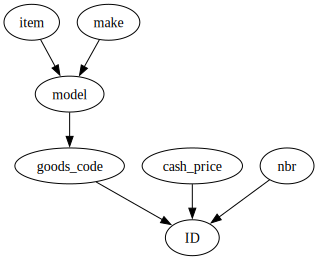

In [3]:
import graphviz as gr

g = gr.Digraph()
g.edge("item", "model")
g.edge("make", "model")
g.edge("model", "goods_code")
g.edge("goods_code", "ID")
g.edge("cash_price", "ID")
g.edge("nbr", "ID")
g

Let's check that our IDs are unique:

In [4]:
X["ID"].nunique() == X.shape[0]

True

Then, what is the cardinality of our features? We only select the first item for simplicity.

In [5]:
cols = ["ID", *[f"{col}1" for col in attribute_cols]]
X[cols].nunique().sort_values()

nbr1              16
item1            134
make1            425
cash_price1     1406
model1          3782
goods_code1     5966
ID             92790
dtype: int64

Interestingly, the cardinality of the `nbr` integer colunm, is fairly low. It might be worth exploring the link between the risk of fraud and outliers like buying 16 instances of a given product.

Also, we see that the cardinality conceptually follows our hierarchical structure: `item` < `make` < `model` < `goods_code` < `ID`.

Let's go further and describe the relationship between `model` and `goods_code`. How many different models are attributed to each `goods_code`?

In [6]:
model_per_code = (
    X.groupby("goods_code1")["model1"].nunique()
    .sort_values(ascending=False)
)
model_per_code

goods_code1
237627610    3
237626283    3
240041014    3
238547749    3
238449041    3
            ..
232452568    0
237235419    0
238665832    0
234714318    0
233004718    0
Name: model1, Length: 5966, dtype: int64

Some codes are associated to up to 3 different models. We give an example below:

In [7]:
X.query("goods_code1 == '239001437'")["model1"].unique()

<StringArray>
['2020 APPLE IPAD 10 2 A12 IPADOS WI-FI 32GB GOLD',
                 '2020 APPLE IPAD 10.2" 32GB GOLD',
                  '2020 APPLE IPAD 10 2 32GB GOLD']
Length: 3, dtype: string

Some codes aren't linked to any model, which is confusing but could be due to a data entry issue.

In [8]:
X.query("goods_code1 == '239773630'")["model1"]

61747    <NA>
Name: model1, dtype: string

Let's quantify these different categories:

In [9]:
model_per_code.value_counts(normalize=True)

model1
1    0.813946
2    0.172813
3    0.007543
0    0.005699
Name: proportion, dtype: float64

Most codes are linked to a single model (82%), but we see that there is not a 1:N relationship like we previously conjectured.

Let's reproduce this experiment with the pairs `item` - `model` and `make` - `item`.

In [10]:
item_by_model = (
    X.groupby("model1")["item1"].nunique()
    .sort_values(ascending=False)
)
item_by_model

model1
RETAILER                                              65
APPLE IPHONE                                           2
OLED65G1                                               2
SONY BRAVIA KE48A9 2020 OLED HDR 4K ULTRA HD SMART     2
APPLE IPHONE 11                                        2
                                                      ..
KUHN RIKON KNIFE SHARPENER GREEN                       1
LA HACIENDA HAWKESBURY MAGNESIA FIREPIT GREY STONE     1
LA HACIENDA SKYLINE STEEL CHIMINEA FIREPIT BLACK       1
LA HACIENDA WESTONBIRT CAST IRON FIREPIT COPPER        1
XR77A80J                                               1
Name: item1, Length: 3782, dtype: int64

Surprisingly, there is not strict 1:N relationship here either. In particular, "RETAILER" is an outlier.

In [11]:
X.query("model1 == 'RETAILER'")["item1"].value_counts().head()

item1
LIVING & DINING FURNITURE    1050
BEDROOM FURNITURE             457
OUTDOOR FURNITURE             411
BABY & CHILD TRAVEL           135
BARBECUES & ACCESSORIES        94
Name: count, dtype: Int64

So "RETAILER" looks like an alternative, catch-all model, encompassing many item kinds. What about the Sony Bravia tv?

In [12]:
model = "SONY BRAVIA KE48A9 2020 OLED HDR 4K ULTRA HD SMART"
X.query("model1 == @model")["item1"].value_counts().head()

item1
TELEVISIONS HOME CINEMA    246
UNKNOWN                      2
Name: count, dtype: Int64

Finally, let's explore the link between `model` and `make`.

In [13]:
item_by_model = (
    X.groupby("model1")["make1"].nunique()
    .sort_values(ascending=False)
)
item_by_model

model1
RETAILER                                              156
MADE TO MEASURE CURTAINS                                5
RETAILER NEWTON MEDIUM 2 SEATER SOFA BE                 1
RETAILER NEWTON LARGE 3 SEATER CHAISE E                 1
RETAILER MORITZ VELVET DINING CHAIR SIL                 1
                                                     ... 
KOTI HOME PLAIN UPHOLSTERED BED FRAME KING SIZE LU      1
KOTI HOME PLAIN UPHOLSTERED BED FRAME SUPER KING S      1
KOTI HOME WINGED BUTTON UPHOLSTERED BED FRAME DOUB      1
KOTI HOME WINGED BUTTON UPHOLSTERED BED FRAME KING      1
XR77A80J                                                1
Name: make1, Length: 3782, dtype: int64

We again see the "RETAILER" model being linked to different maker. Apart from that, only a single model is linked to different makers.

In [14]:
X.query("model1 == 'MADE TO MEASURE CURTAINS'")["make1"].value_counts().head()

make1
RETAILER                      13
SANDERSON                      3
MORRIS CO                      2
DESIGN PROJECT BY RETAILER     2
DESIGNERS GUILD                2
Name: count, dtype: Int64

So "RETAILER" is a model but also a maker, which starts to be confusing.

In [15]:
X.loc[(X == "RETAILER").any(axis=1)]

ID                             item1  \
6      113204           TELEVISIONS HOME CINEMA   
15     108706                         COMPUTERS   
17      88776                 BEDROOM FURNITURE   
19       9281         LIVING & DINING FURNITURE   
22      49664           TELEVISIONS HOME CINEMA   
...       ...                               ...   
92778   80471                         COMPUTERS   
92780   55026           LIVING DINING FURNITURE   
92782   41993                         COMPUTERS   
92784   95939                         COMPUTERS   
92785   21243  COMPUTER PERIPHERALS ACCESSORIES   

                                  item2              item3 item4 item5 item6  \
6                               SERVICE               <NA>  <NA>  <NA>  <NA>   
15     COMPUTER PERIPHERALS ACCESSORIES  FULFILMENT CHARGE  <NA>  <NA>  <NA>   
17                    BEDROOM FURNITURE               <NA>  <NA>  <NA>  <NA>   
19            LIVING & DINING FURNITURE  FULFILMENT CHARGE  <NA>  <NA>  <NA>   
22                    FULFILMENT CHARGE               <NA>  <NA>  <NA>  <NA>   
...                                 ...                ...   ...   ...   ...   
92778                 FULFILMENT CHARGE               <NA>  <NA>  <NA>  <NA>   
92780           LIVING DINING FURNITURE               <NA>  <NA>  <NA>  <NA>   
92782  COMPUTER PERIPHERALS ACCESSORIES  FULFILMENT CHARGE  <NA>  <NA>  <NA>   
92784                 FULFILMENT CHARGE               <NA>  <NA>  <NA>  <NA>   
92785                 FULFILMENT CHARGE               <NA>  <NA>  <NA>  <NA>   

      item7 item8 item9  ... nbr16 nbr17 nbr18 nbr19 nbr20 nbr21 nbr22 nbr23  \
6      <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
15     <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
17     <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
19     <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
22     <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
...     ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
92778  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
92780  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
92782  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
92784  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
92785  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   

      nbr24 Nb_of_items  
6      <NA>           2  
15     <NA>           3  
17     <NA>           2  
19     <NA>           3  
22     <NA>           2  
...     ...         ...  
92778  <NA>           2  
92780  <NA>           2  
92782  <NA>           3  
92784  <NA>           2  
92785  <NA>           2  

[38501 rows x 146 columns]

## 3. Exploring the target

We now switch gears and load the target, before merging it with the feature table.

In [16]:
y = pd.read_csv("Y_train.csv", index_col="index")
y

ID  fraud_flag
index                   
0      85517           0
1      51113           0
2      83008           0
3      78712           0
4      77846           0
...      ...         ...
92785  21243           0
92786  45891           0
92787  42613           0
92788  43567           0
92789  68268           0

[92790 rows x 2 columns]

As a safety measure and to mitigate the risk of overfitting, we only analyse the data we will later use for training.

In [17]:
from sklearn.model_selection import train_test_split

target_col = "fraud_flag"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.1, stratify=y[target_col],
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83511, 146), (9279, 146), (83511, 2), (9279, 2))

We merge our training dataset with our training target to derive more insights.

In [18]:
df = X_train.merge(y_train, on="ID")
df.shape

(83511, 147)

Our very imbalanced target distribution:

fraud_flag
0    0.985786
1    0.014214
Name: proportion, dtype: float64


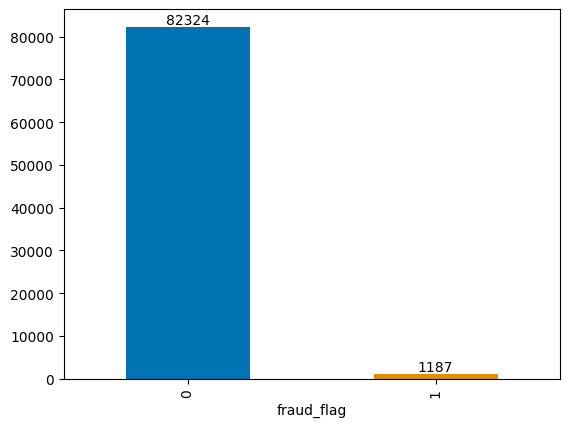

In [19]:
palette = sns.color_palette('colorblind', n_colors=2)
ax = df[target_col].value_counts().plot.bar(color=palette);
ax.bar_label(ax.containers[0])
print(df[target_col].value_counts(normalize=True))

One thousand positive class is fairly low, but should be enough to ensure some predictive power.

Next, we want to make sure that `Nb_of_items` is correlated with the number of items that aren't None, for all item attributes.

In [20]:
for col in attribute_cols:
    cols = get_group_cols(col)
    n_not_nulls = df[cols].notnull().sum(axis=1)
    corr = np.corrcoef(n_not_nulls, df['Nb_of_items'])[0][1]
    print(col, f"{corr:.4f}")

item 0.9863
cash_price 0.9863
make 0.9745
model 0.9745
goods_code 0.9863
nbr 0.9863


That assumption looks correct. 

Let's now answer a question we asked previously, by displaying the distribution of the number of **unique** items given the fraud.

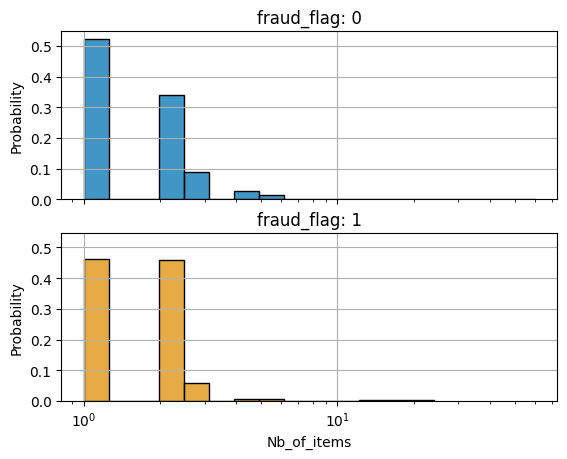

In [21]:
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
for idx, ax in enumerate(axes):
    sns.histplot(
        df.loc[df[target_col] == idx]["Nb_of_items"],
        log_scale=[True, False],
        bins=MAX_ITEMS,
        binwidth=.1,
        stat="probability",
        color=palette[idx],
        ax=ax,
    );
    ax.set_title(f"{target_col}: {idx}")
    ax.grid()

It's quite clear that extremely few baskets have more than 5 different items in them.

We see that there is a higher proportion of basket with 2 items in the fraud case.

Are there specific categories of items where frauders buy more different product?

/Users/vincentmaladiere/dev/probabl/mandr/examples/fraud/eda_plots.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  l = ax.legend()


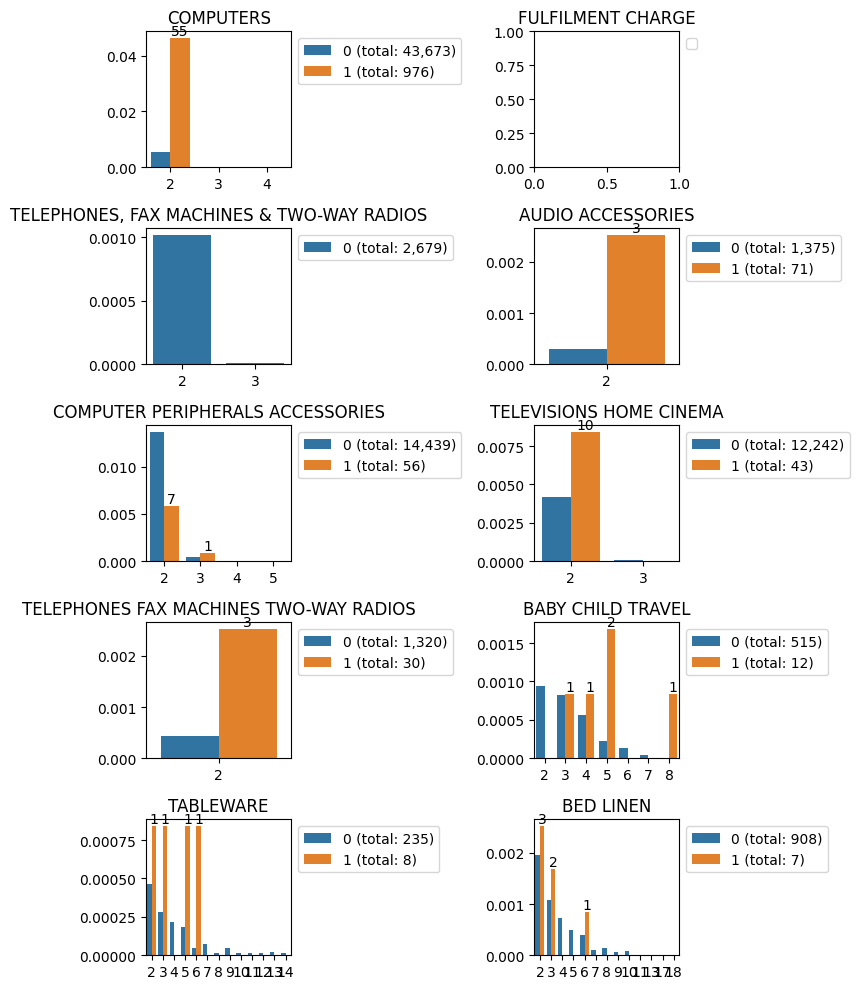

In [22]:
from eda_plots import plot_n_items_per_basket

plot_n_items_per_basket(df, n_most_freq=10)

The most striking difference is with the computers category: fraudsters order 2 different computers 5% of the time, while legit buyers do so less than 1% of the time.

Fulfilment charge is never ordered twice.

This raises a related question: do frauders buy more instances of the same article? E.g. several pairs of Apple airpods or more than one computer of the same model?

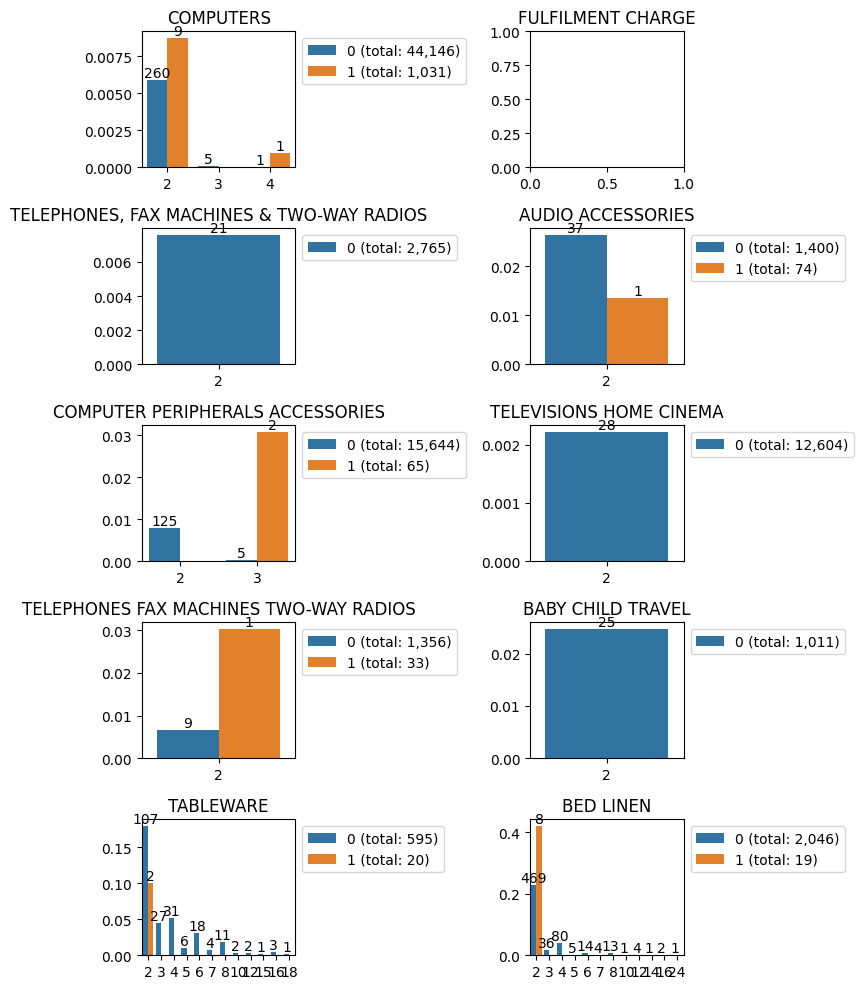

In [23]:
from eda_plots import plot_nbr_per_item

plot_nbr_per_item(df, n_most_freq=10)

Fraudsters don't stand out on buying the same item multiple times, so we can expect the `nbr{i}` feature to play little role in the fraud prediction performance.

So, a frauders' trick could be to buy different computer models instead of the same model multiple times.

## 4. Price distribution

We can expect price to be a significant feature for prediction. Let's start by computing the total basket price.

In [24]:
def compute_total_price(df):
    price_cols = get_group_cols("cash_price")
    nbr_cols = get_group_cols("nbr")
    df["total_price_"] = 0
    for price_col, nbr_col in zip(price_cols, nbr_cols):
        df["total_price_"] += df[price_col].fillna(0) * df[nbr_col].fillna(0)
    return df

df = compute_total_price(df)

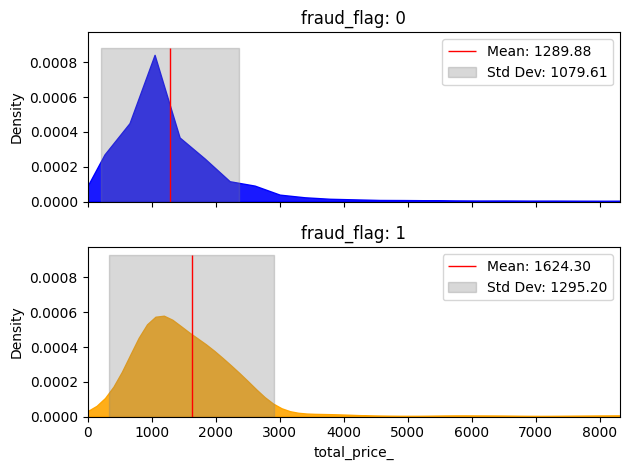

In [25]:
from eda_plots import plot_price_distribution

plot_price_distribution(df)

Let’s estimate a very simple model. We will regress log price of baskets on the fraud indicator. We use logs here so that [our parameter estimates have a percentage interpretation](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th). With it, we will be able to say that a fraud yields a price increase of x%.

In [26]:
import statsmodels.formula.api as smf

result = smf.ols(f'np.log(total_price_) ~ {target_col}', data=df).fit()
result.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

The difference in price means between the fraud and the legit credits is significant. By using the log of the total price, 
we find that a fraud increases the price of the basket by 26.9%.

In [27]:
df.query(f"{target_col} == 0")["total_price_"].describe()

count        82324.0
mean     1289.879258
std      1079.613906
min            219.0
25%            779.0
50%           1099.0
75%           1507.0
max          77355.0
Name: total_price_, dtype: Float64

In [28]:
df.query(f"{target_col} == 1")["total_price_"].describe()

count         1187.0
mean     1624.299916
std      1295.197799
min            305.0
25%            999.0
50%           1379.0
75%           1899.0
max          24551.0
Name: total_price_, dtype: Float64

Interestingly, the fraudster maximum outlier is far from the maximum legit basket, and the median are lower than the means, indicating a skew toward the large values.

We now display the price distribution of the item categories that are the most subject to fraud:

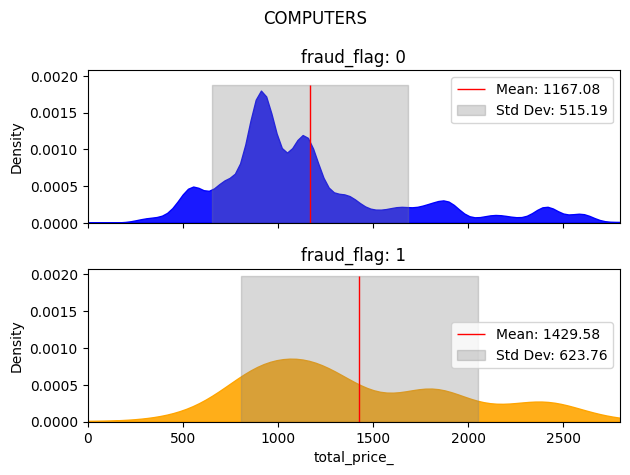

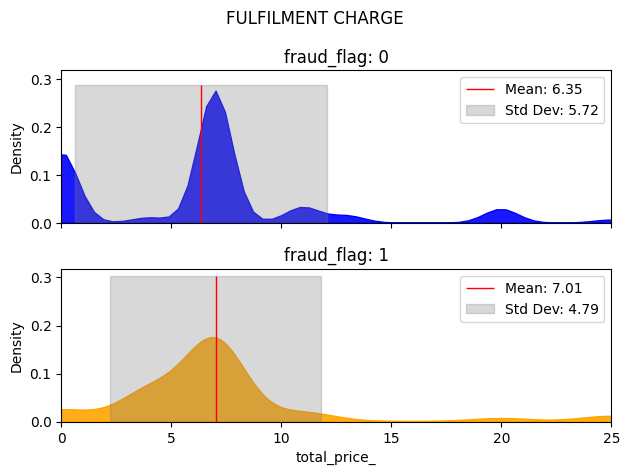

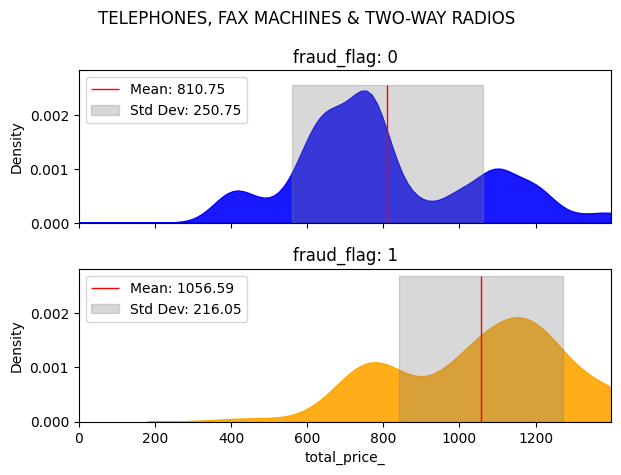

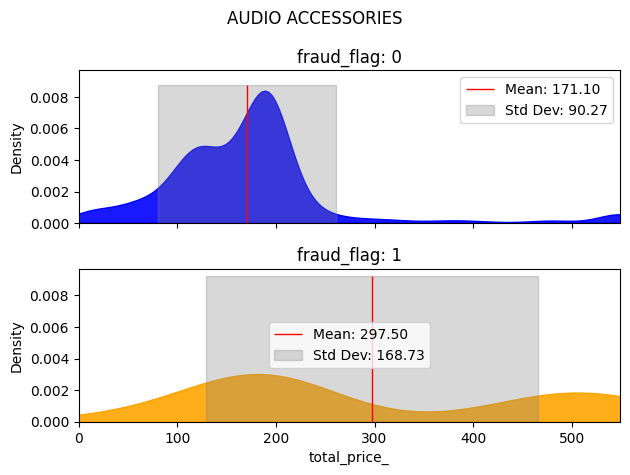

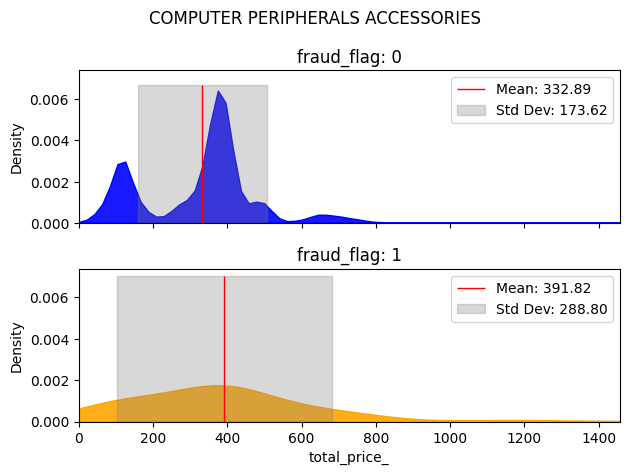

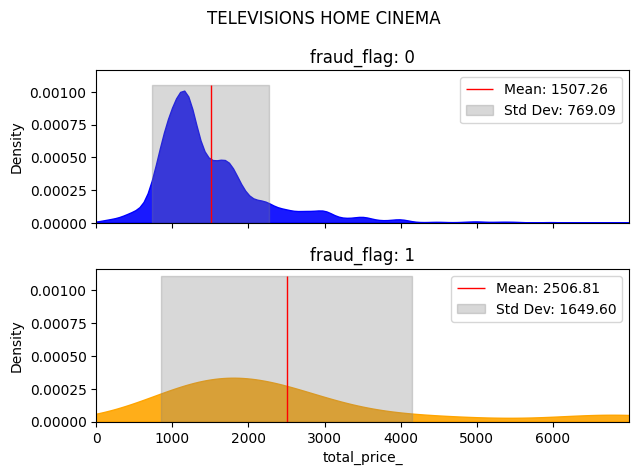

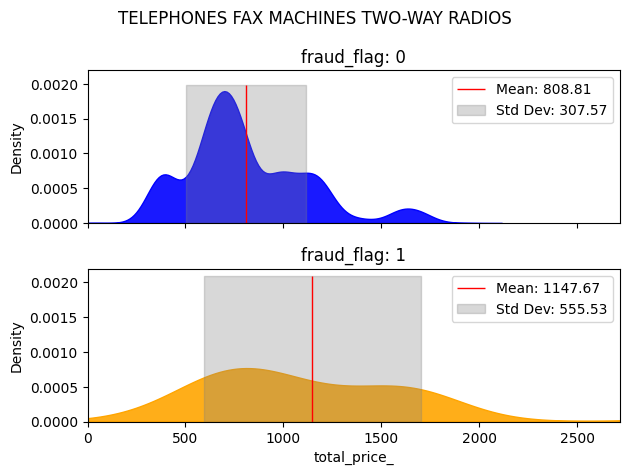

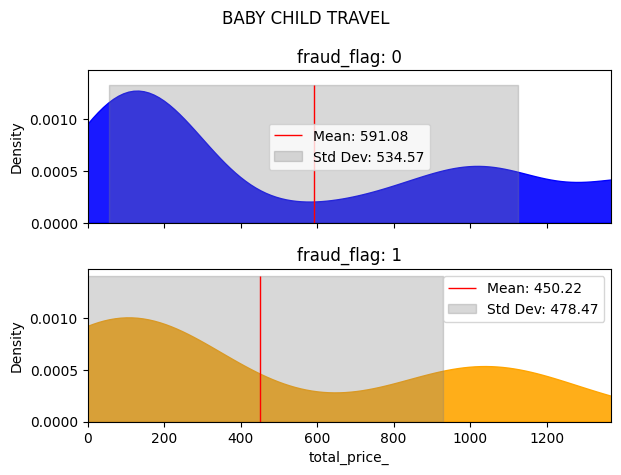

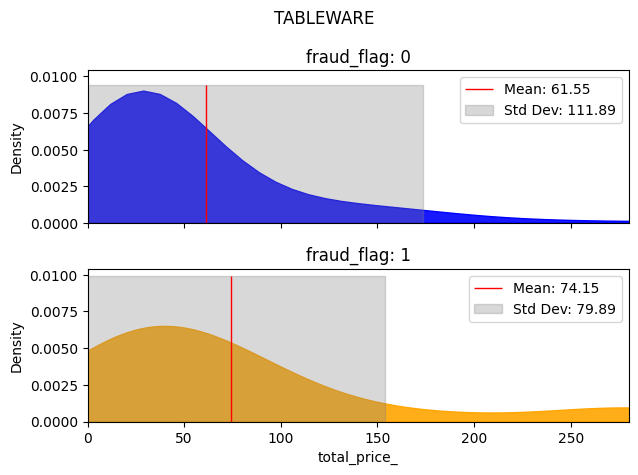

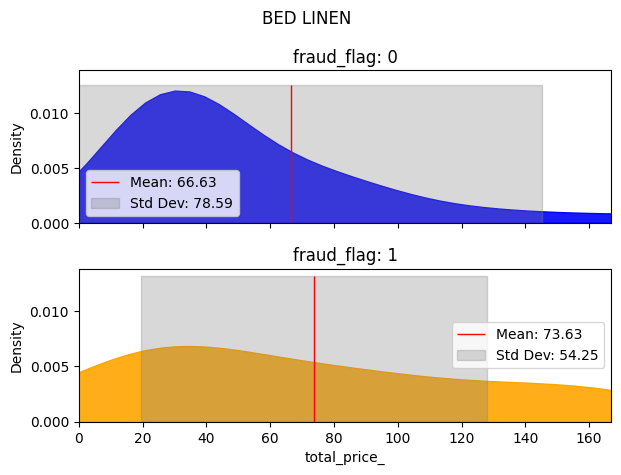

In [29]:
from eda_plots import plot_multiple_price_dist

plot_multiple_price_dist(df, n_most_freq=10)

Computers, phones, audio accessory and home cinema show a difference in means that looks significant.

## 5. Co-occurence graph

We now studies the co-occurences of items and models.

In [30]:
def clean_items(df):
    """Small cleaning step.
    """
    for item_col in get_group_cols("item"):
        df[item_col] = df[item_col].str.replace("& ", "").str.replace(",", "")
    return df

df = clean_items(df)

We begin with plotting the co-occurence graph of the legit credits.

The size of the nodes is proportional to the frequency of the represented entities (either item or make), and the width of the edges is proportional to the co-occurence of their two nodes. We only represent the most frequent entities, as speficied by the `top` argument.

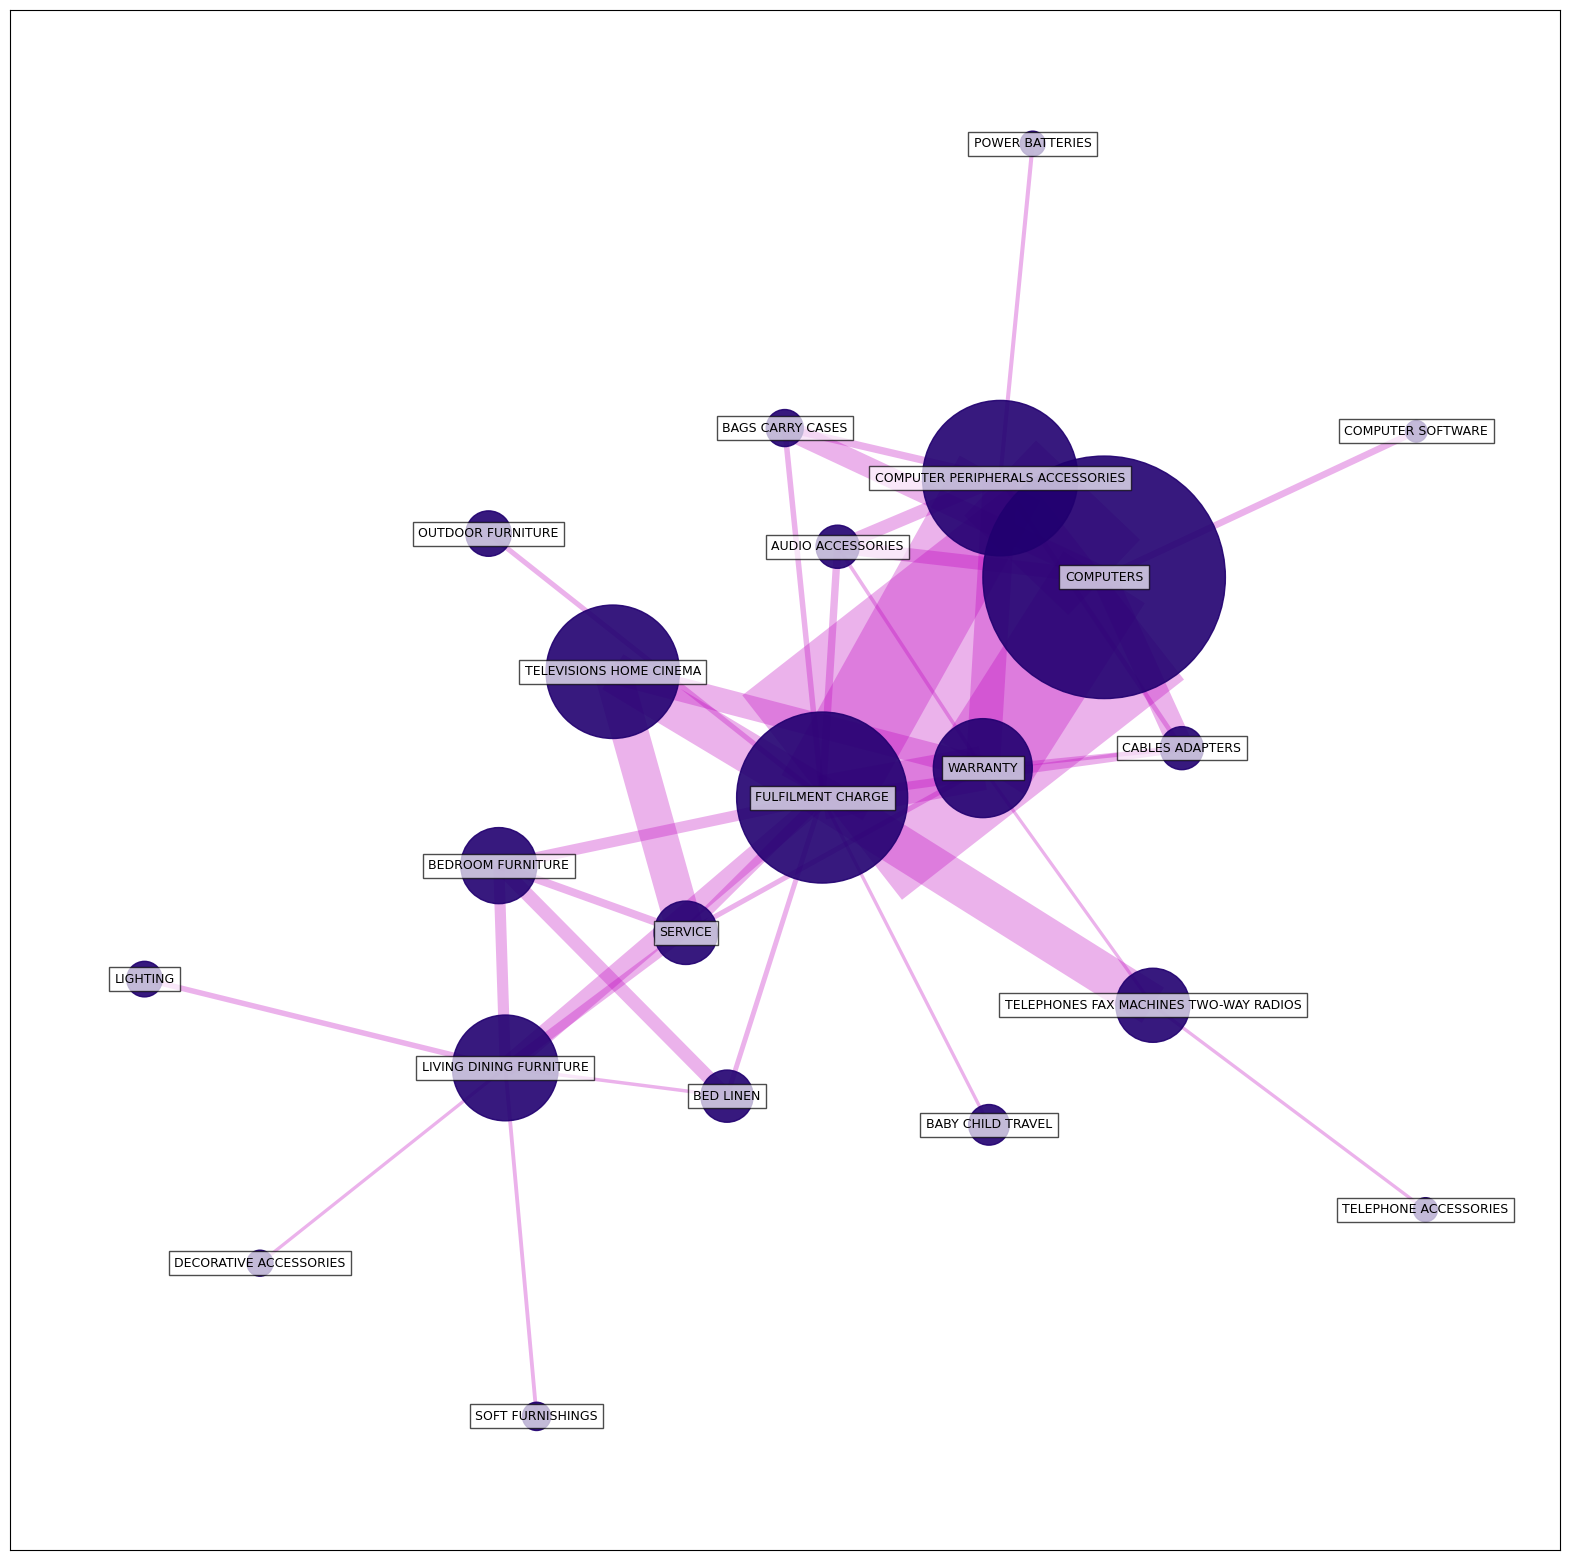

In [31]:
from eda_plots import plot_graph

plot_graph(
    df.loc[df[target_col] == 0],
    column="item",
    top=40,
)

Computers are the most represented category, and seems to go in pair with fulfilment charge.

Let's now plot the same graph for fraudulent credits only:

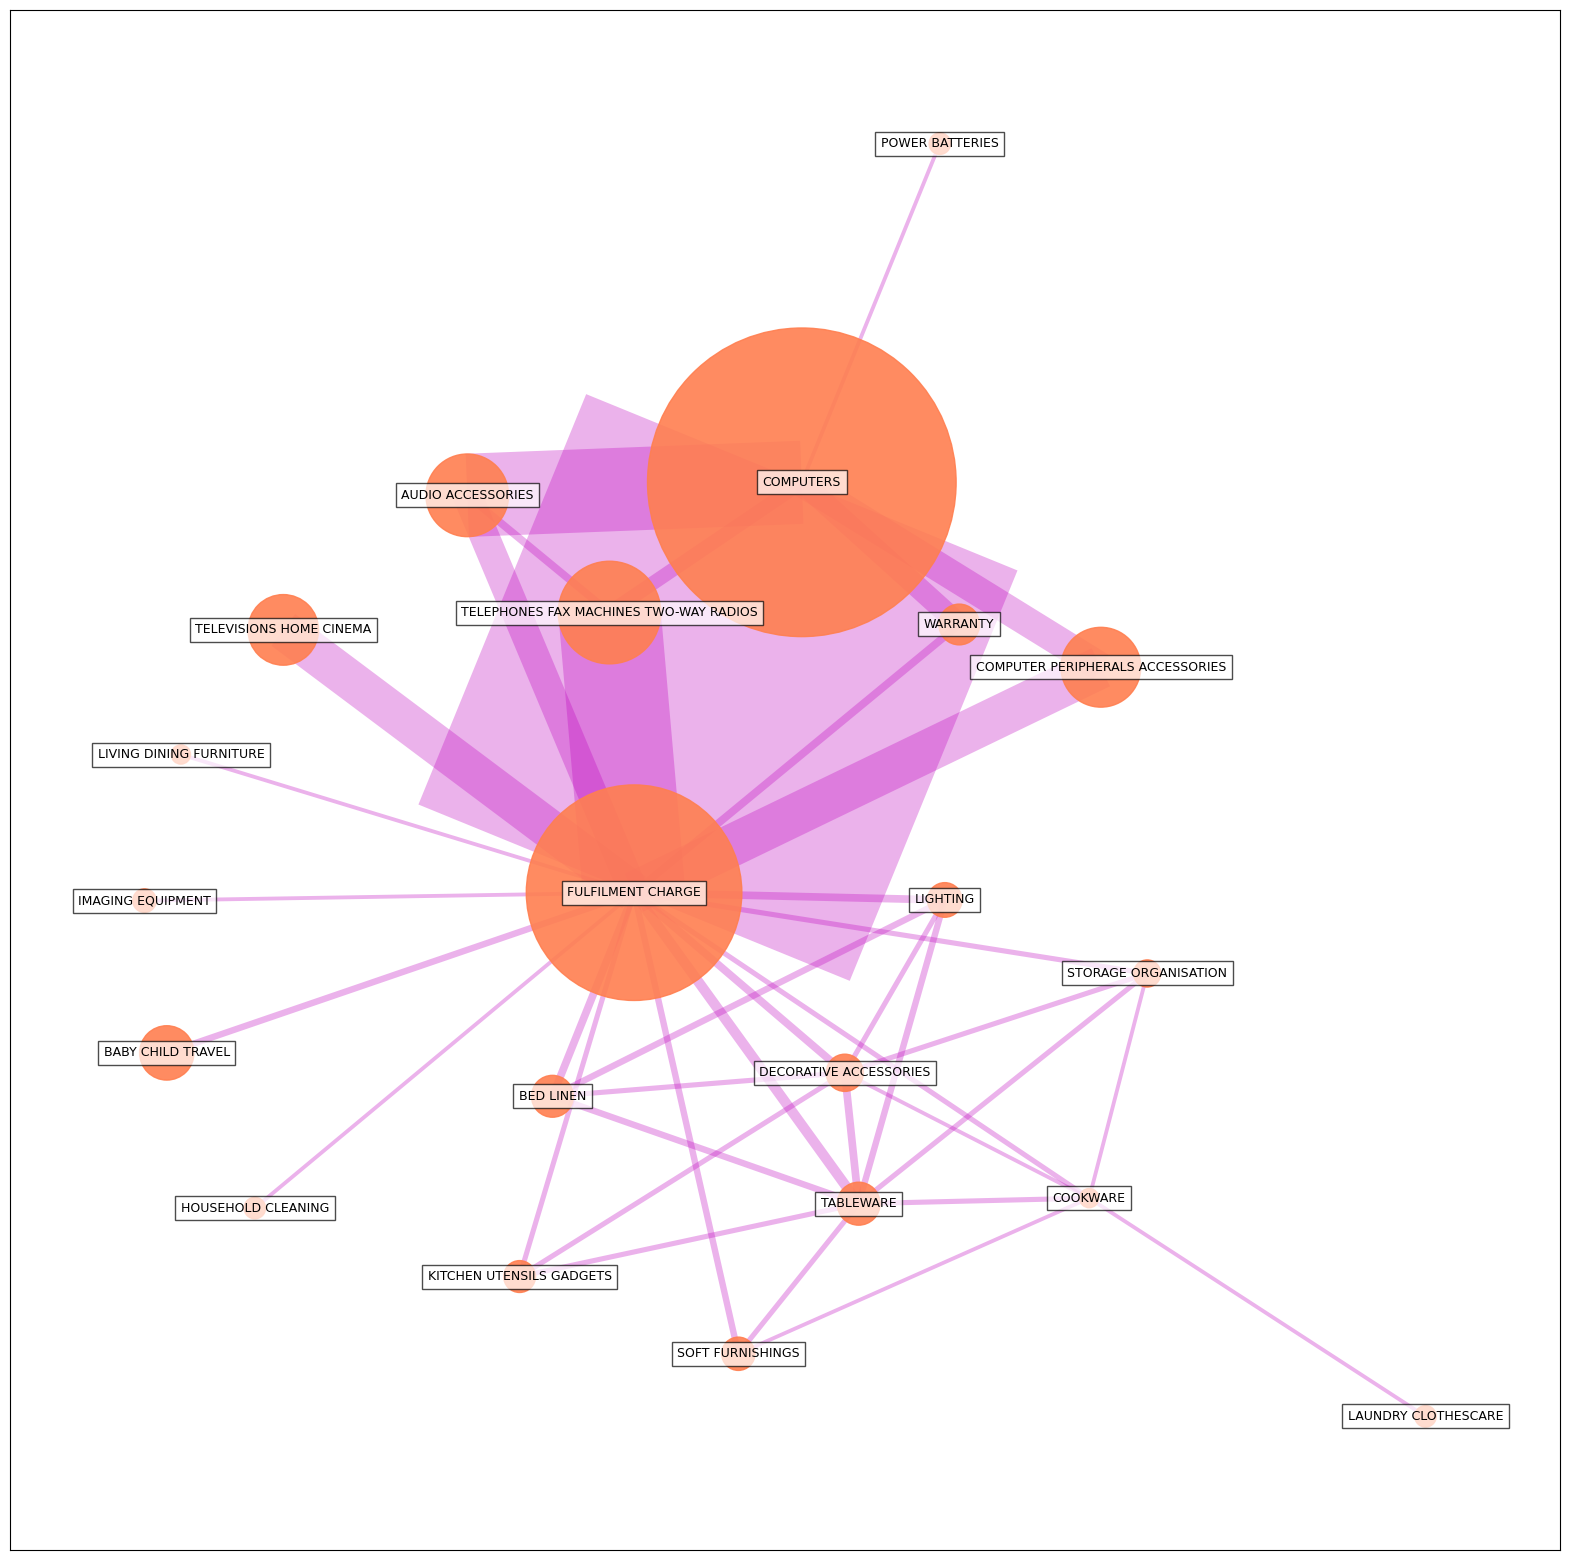

In [32]:
plot_graph(
    df.loc[df[target_col] == 1],
    column="item",
    top=40,
    node_color="coral",
)

Computer and fulfilment charge are still the most represented items, but we also notice a diversification around tableware and decorative accessories.

We now focus on the co-occurence of the brands:

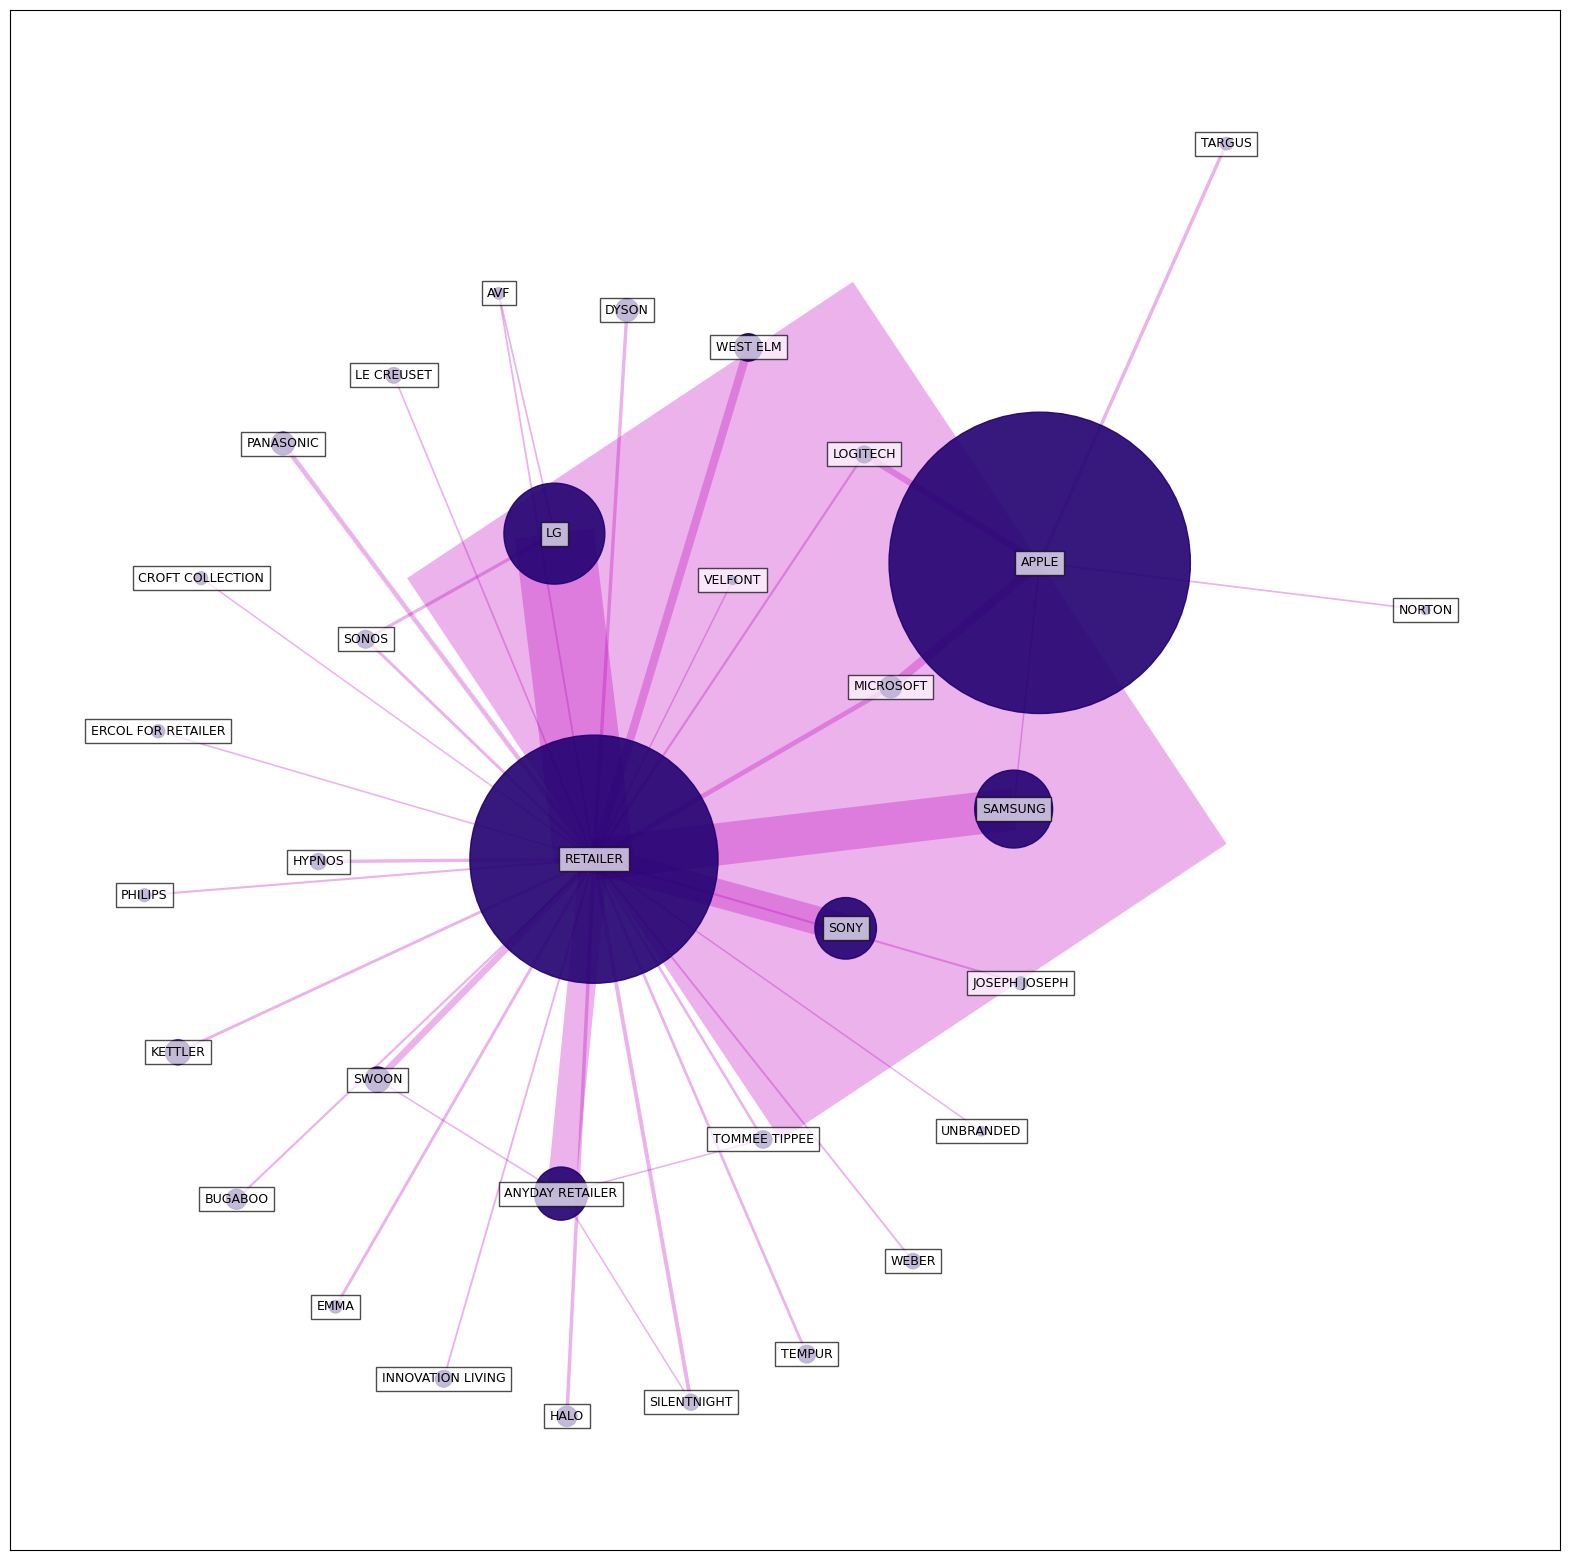

In [33]:
plot_graph(
    df.loc[df[target_col] == 0],
    column="make",
    top=40,
)

We understand that the fulfilment charge are provided by the retailer for many different products, and as we previously saw, this is not a huge differenciator for fraud. Apple (and to a lesser extend, Samsung) is the previous computers and phone nodes.

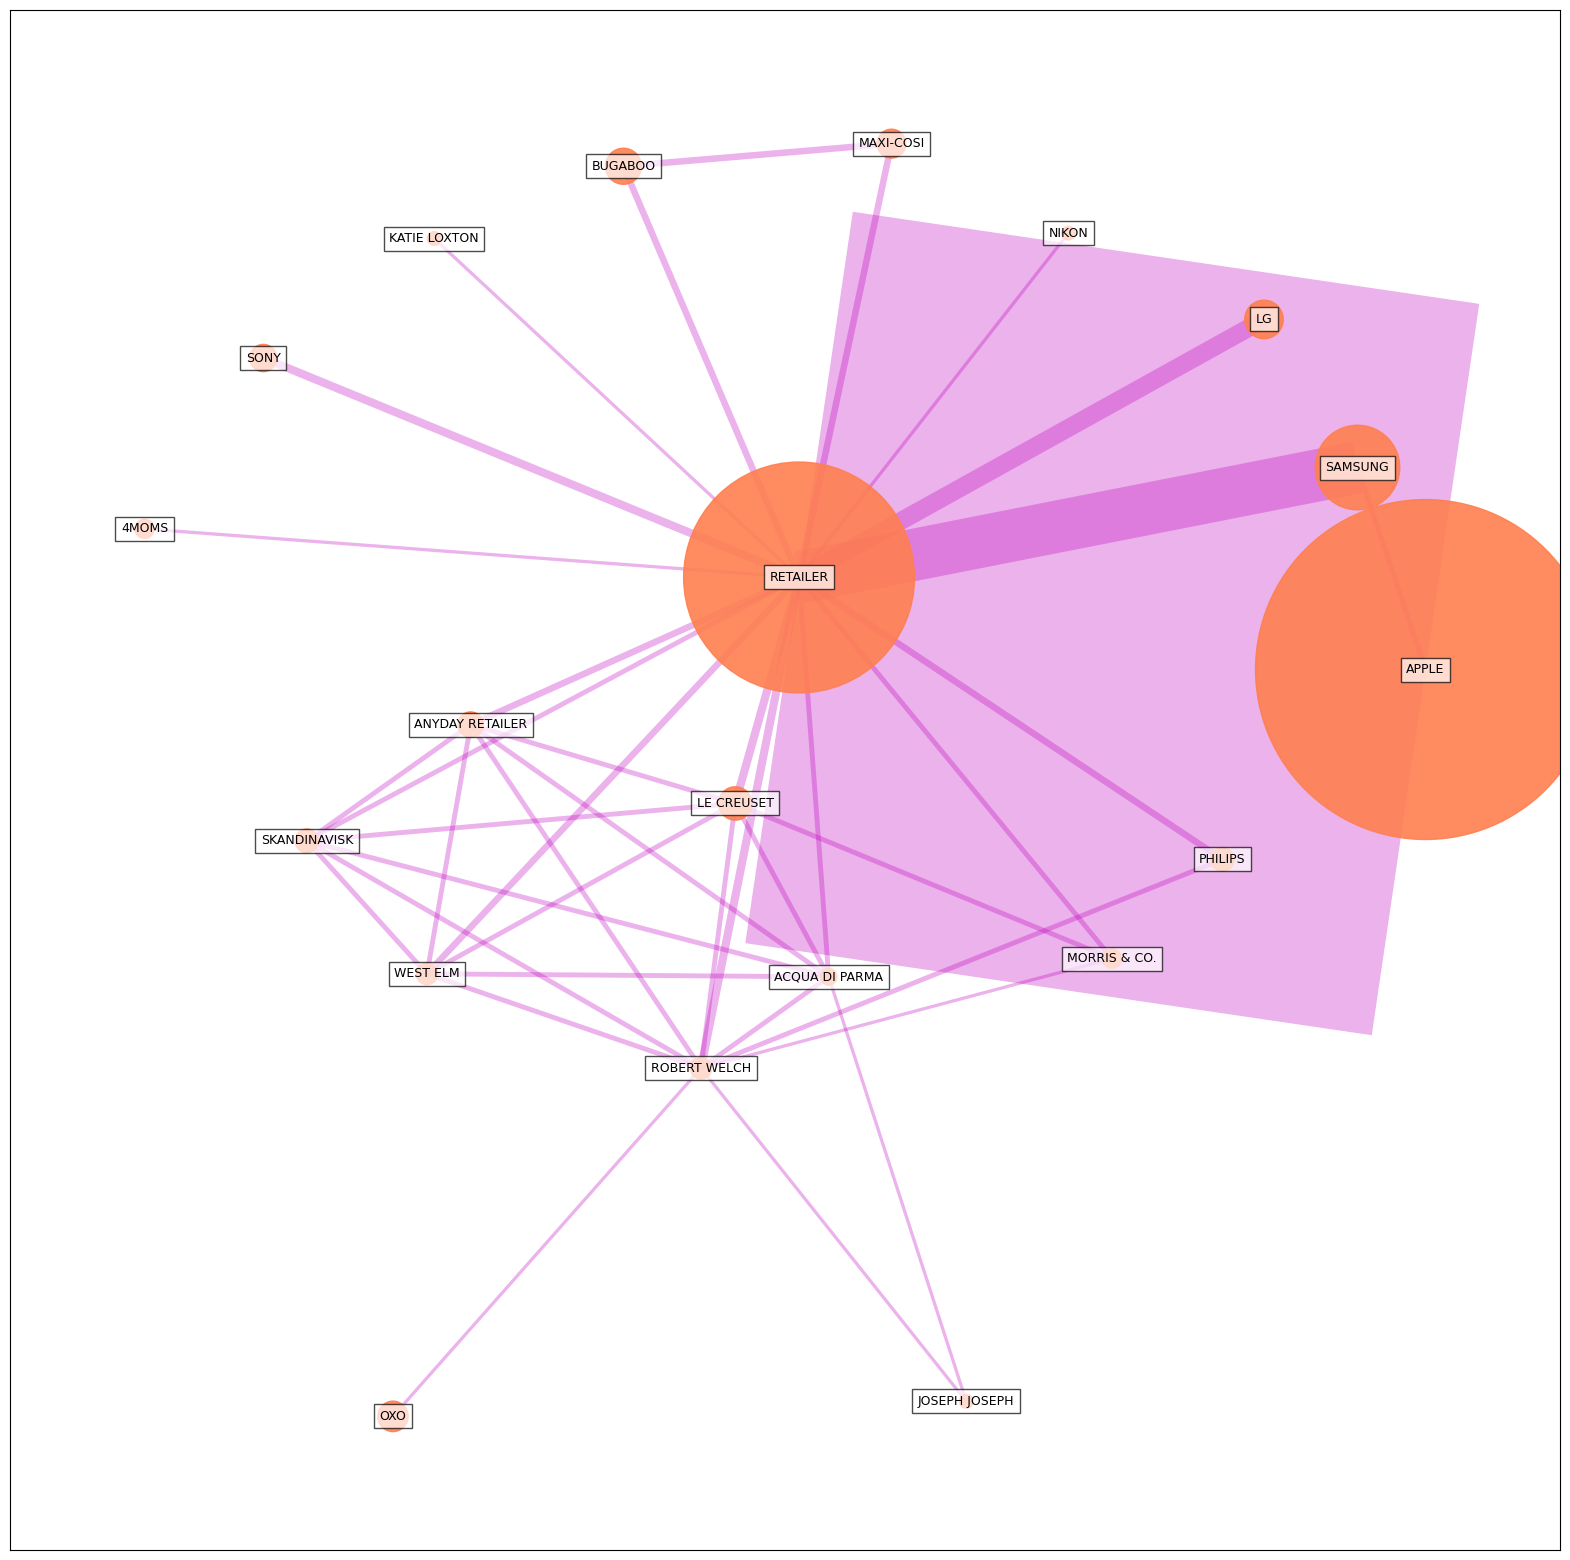

In [34]:
plot_graph(
    df.loc[df[target_col] == 1],
    column="make",
    top=40,
    node_color="coral",
)

Microsoft, Sony and LG are visibly less prefered by fraudsters.

We can also notice the subgraph created by the smaller categories, whereas the previous legit graph was more centralized around RETAILER.

To get a more exhaustive perspective on these graph relations, we can focus on the adjacency matrix of two columns, and observe which combinations had seen the most frauds.

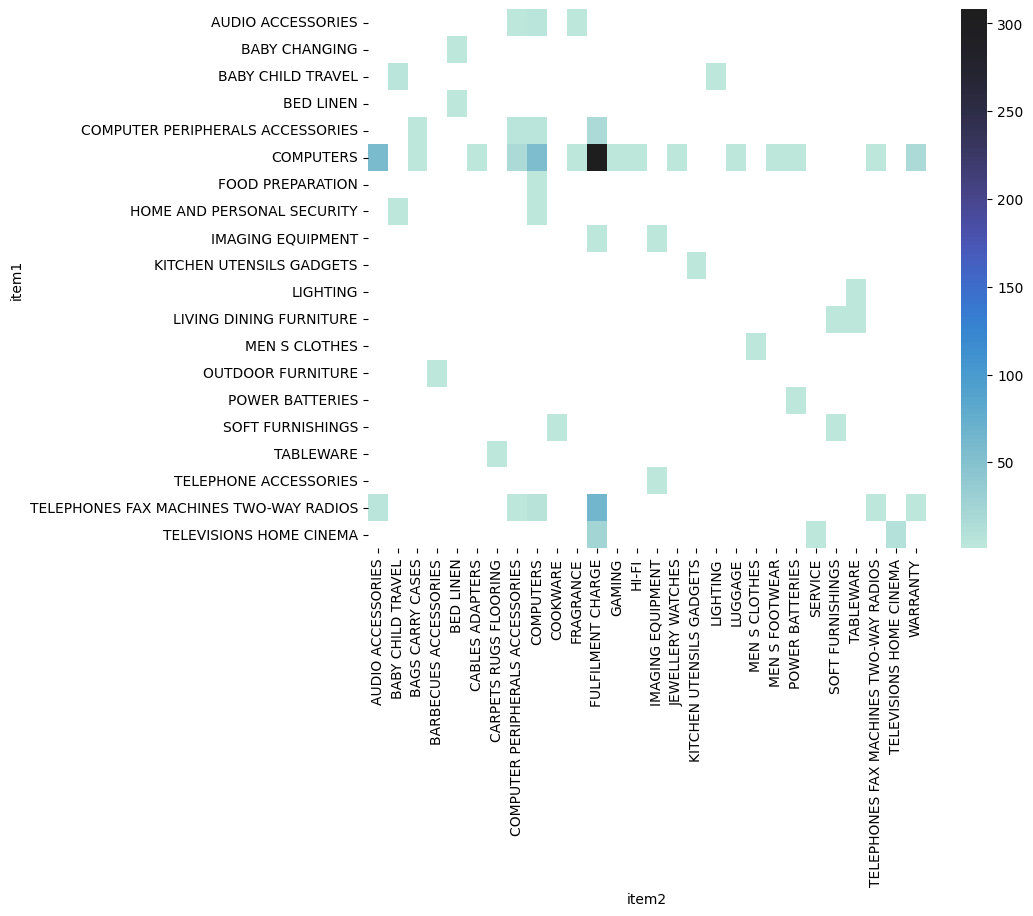

In [35]:
def plot_adjacency_matrix(df, col1, col2, figsize=(9, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    df = (
        df.groupby([col1, col2])[target_col]
          .sum()
          .reset_index()
          .pivot(index=col1, columns=col2, values=target_col)
    )
    sns.heatmap(df, center=df.max(axis=None), ax=ax)

plot_adjacency_matrix(df.loc[df[target_col] == 1], "item1", "item2")

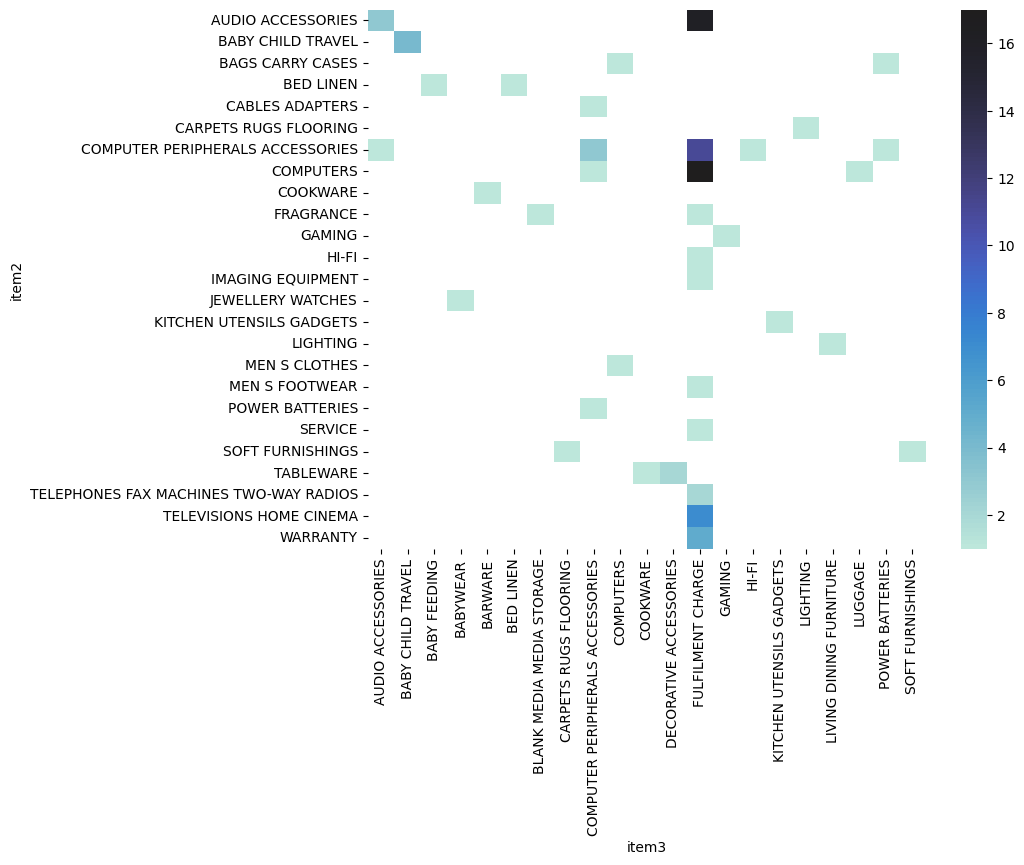

In [36]:
plot_adjacency_matrix(df.loc[df[target_col] == 1], "item2", "item3")

Notice how the maximum value of the colorbar shrinks when we go from the item1/item2 matrix to the item2/item3 matrix.

Fulfilment charge appears at multiple positions. One hypothesis is that it is automatically added to the basket after the last item.

The following plot drills into brands to show the models that are the most targeted by fraudsters.

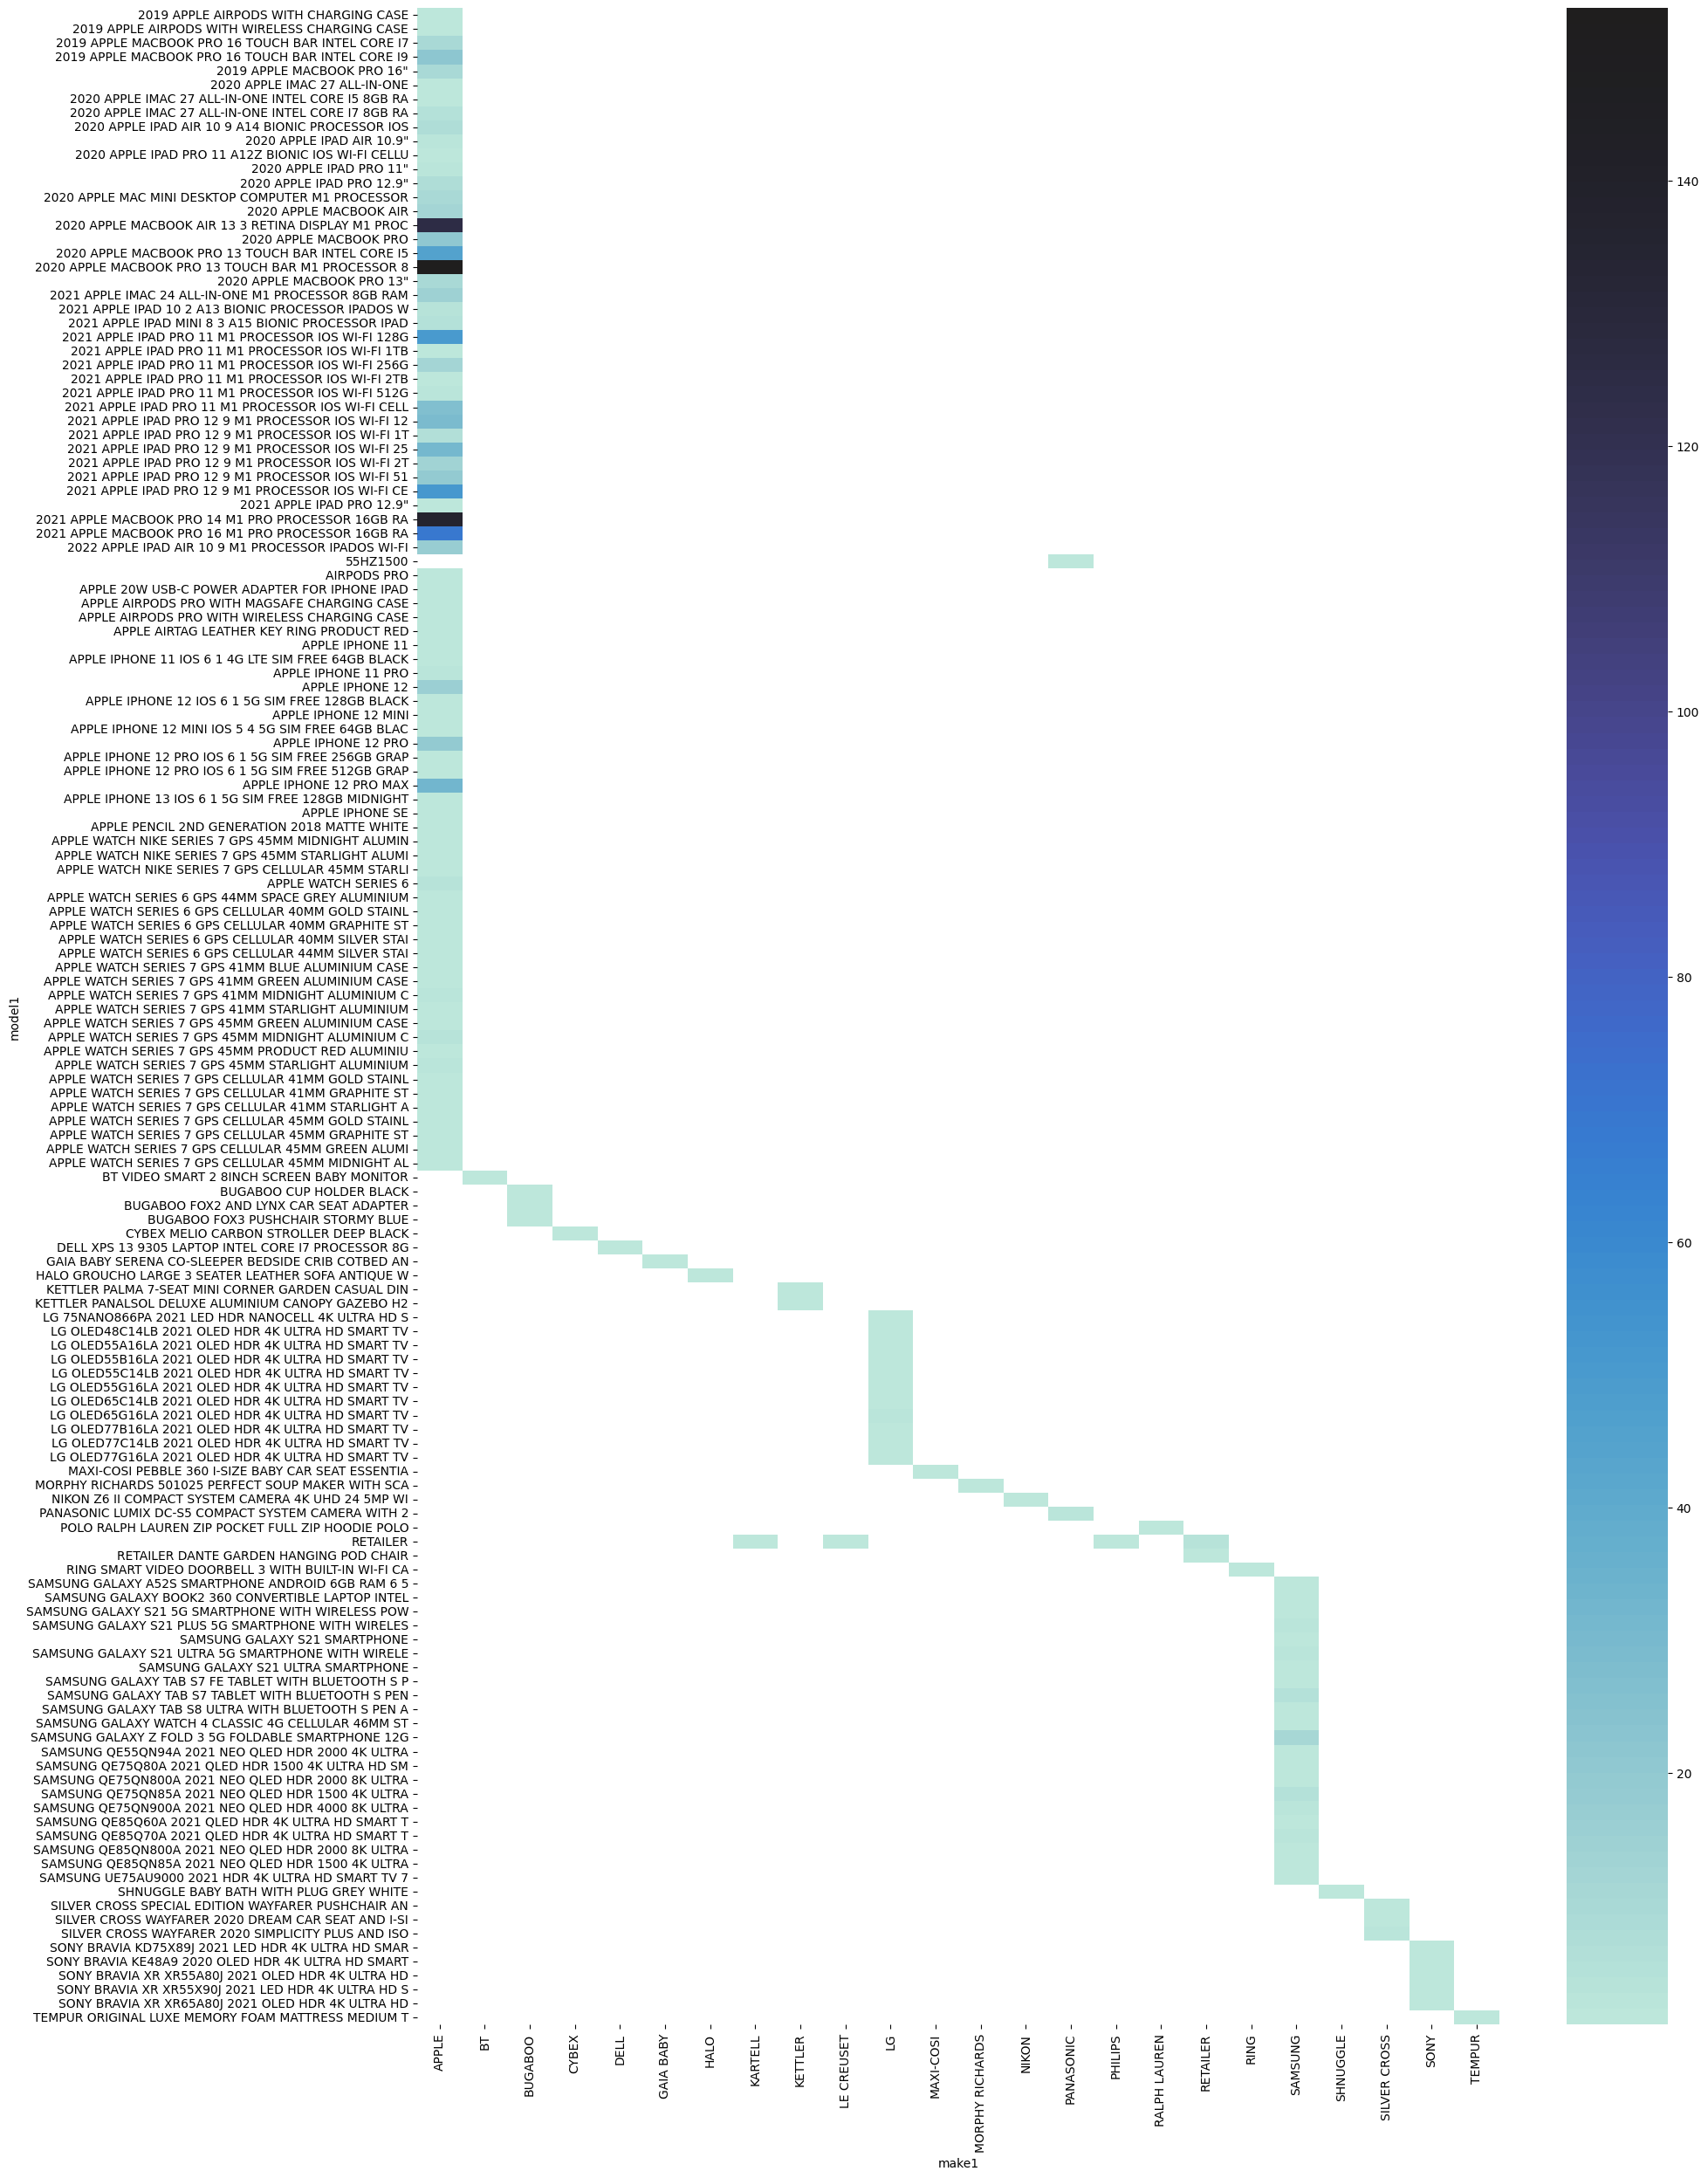

In [37]:
plot_adjacency_matrix(
    df.loc[df[target_col] == 1],
    "model1",
    "make1",
    figsize=(20, 30),
)

Noticeably, Apple MacBook Air and MacBook Pro models are the most subject to fraud.

## 6. Marginal fraud ratios

We just saw that Apple products were the most targeted by fraud in absolute numbers. We now compare items and makers individually, relatively to the average fraud ratio.

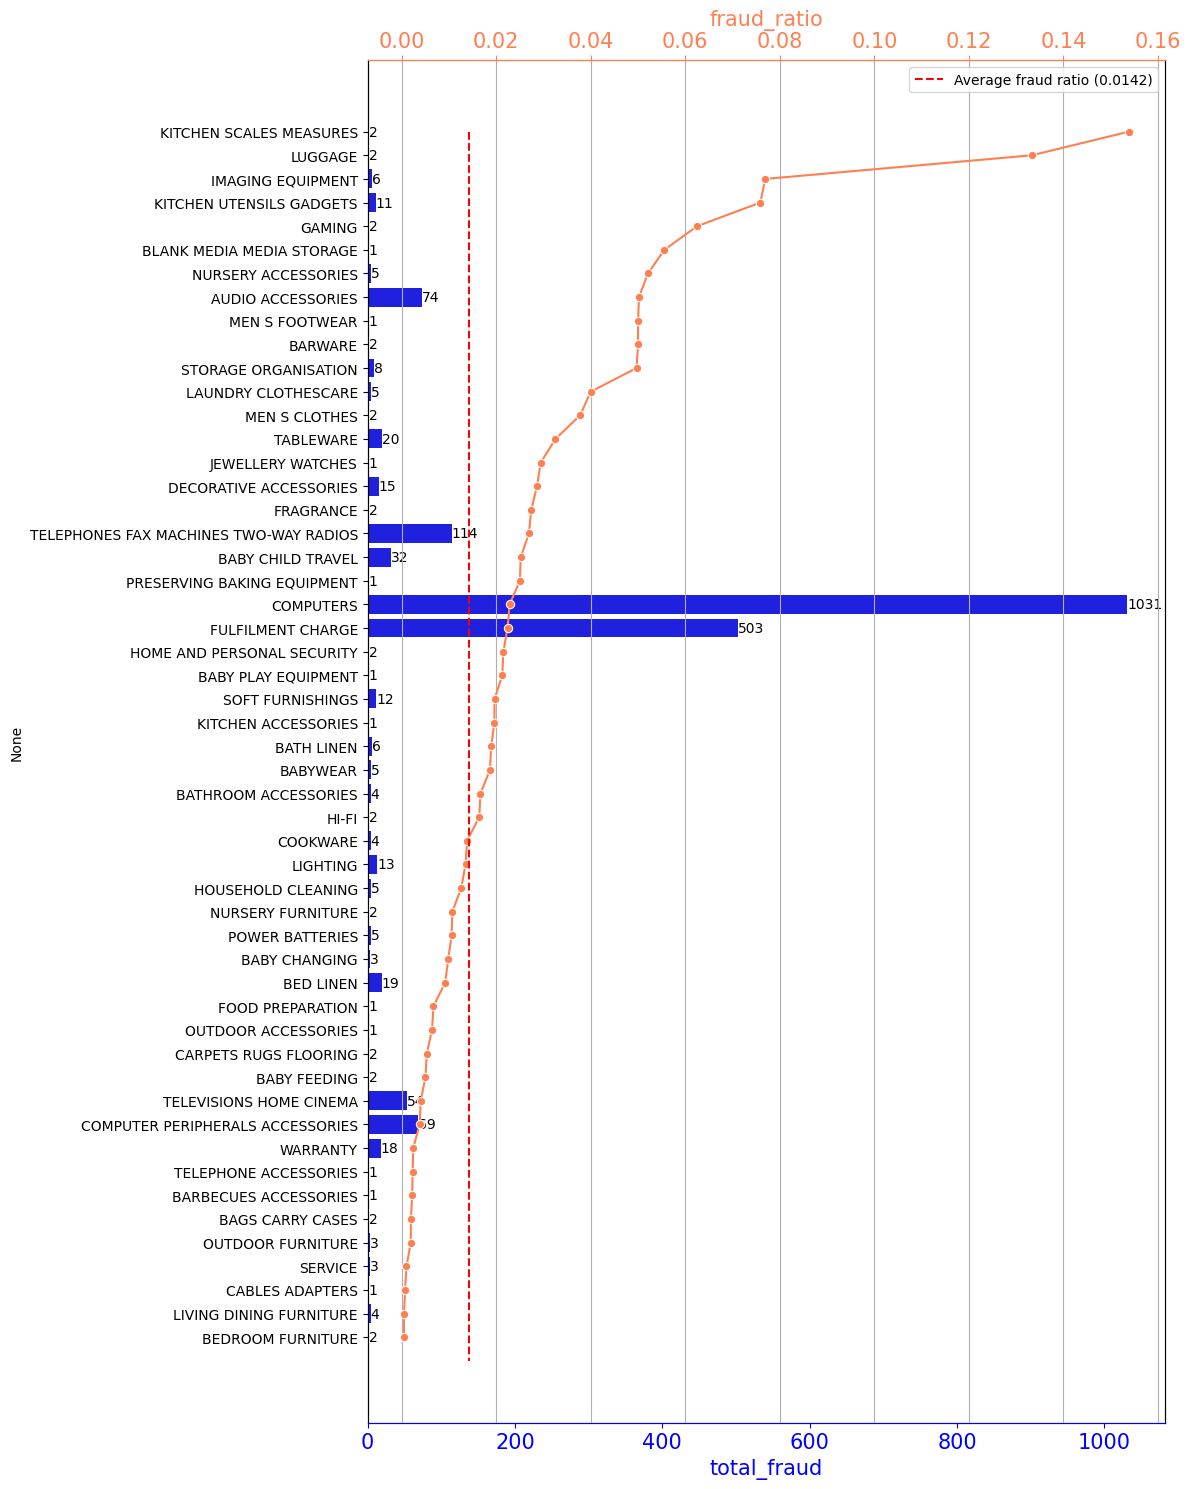

In [38]:
from eda_plots import plot_fraud_ratio

plot_fraud_ratio(df, "item")

Items that are on the right of the red dashed line have a higher fraud ratio than the global average. The blue bars quantify the total number of fraud that occured for the same categories. Notably, audio accessories are 3x more likely to be linked to a fraud that the average.

We reproduce the same graph with makers:

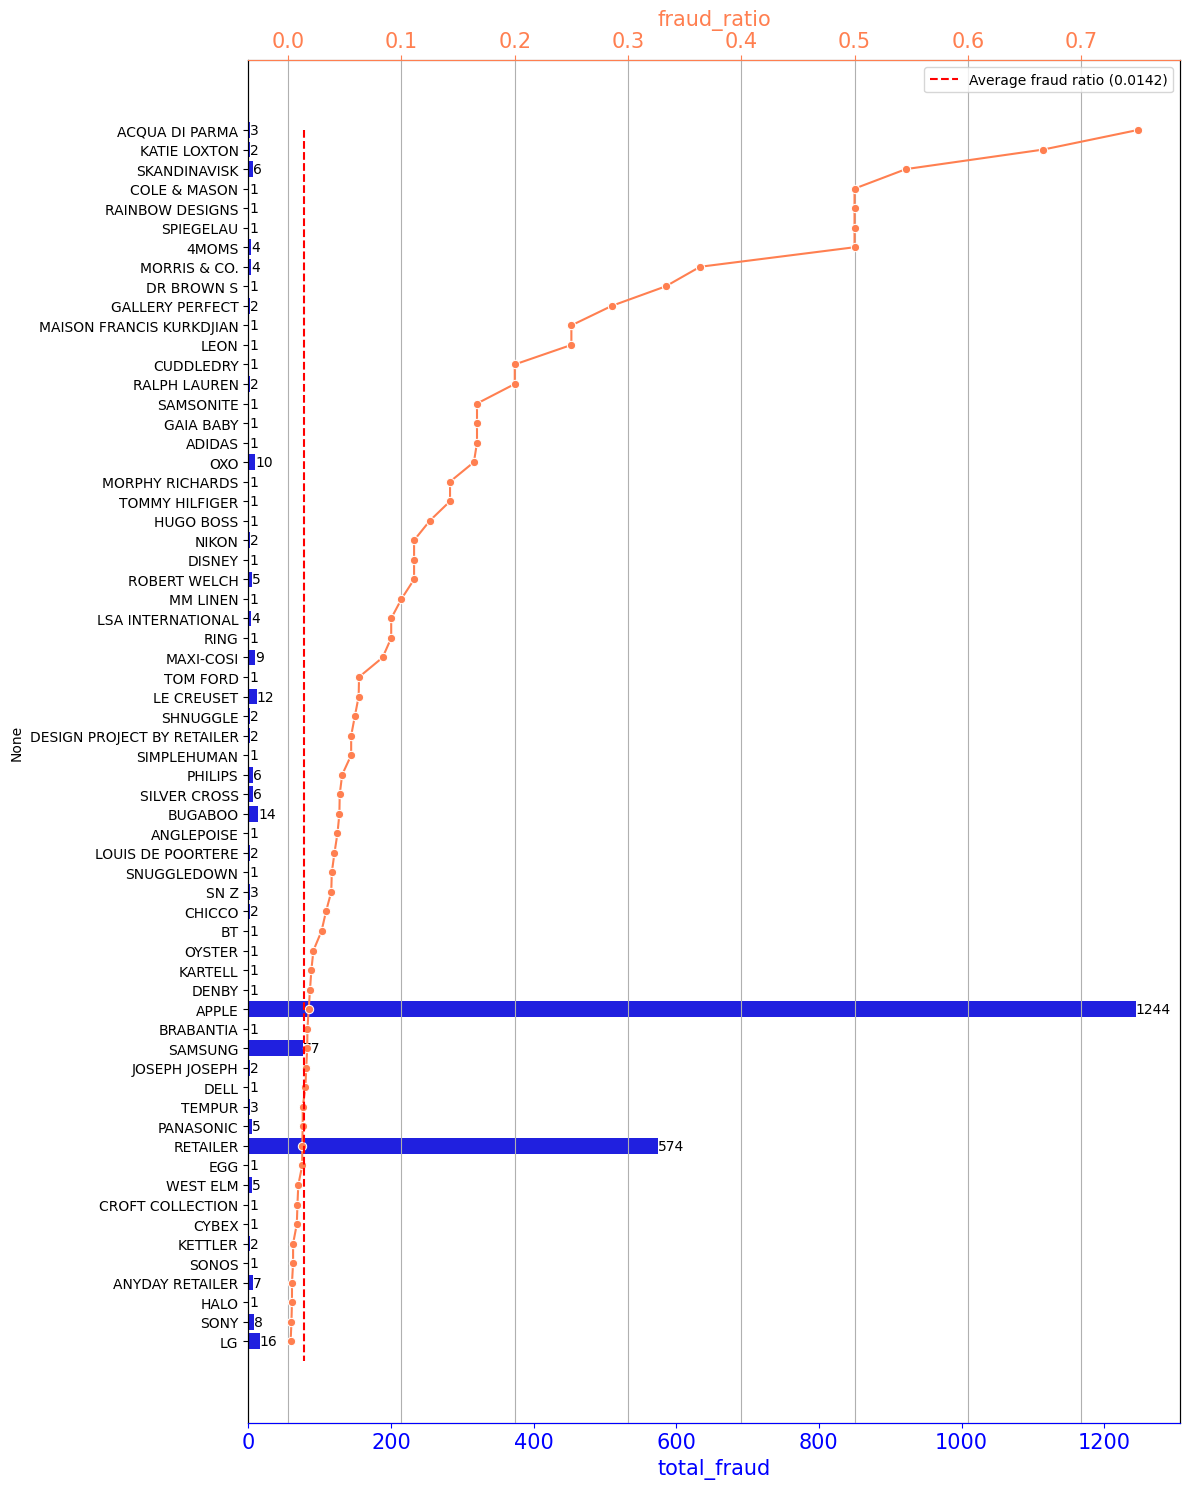

In [39]:
plot_fraud_ratio(df, column="make")

No brands stand out, and the ones with the highest fraud ratio have actually seen very few fraud cases. Apple is super close to the average, which is not surprising because due to its number of purchase, it actually sets the average.

Finally, let's run this graph one more time for the models.

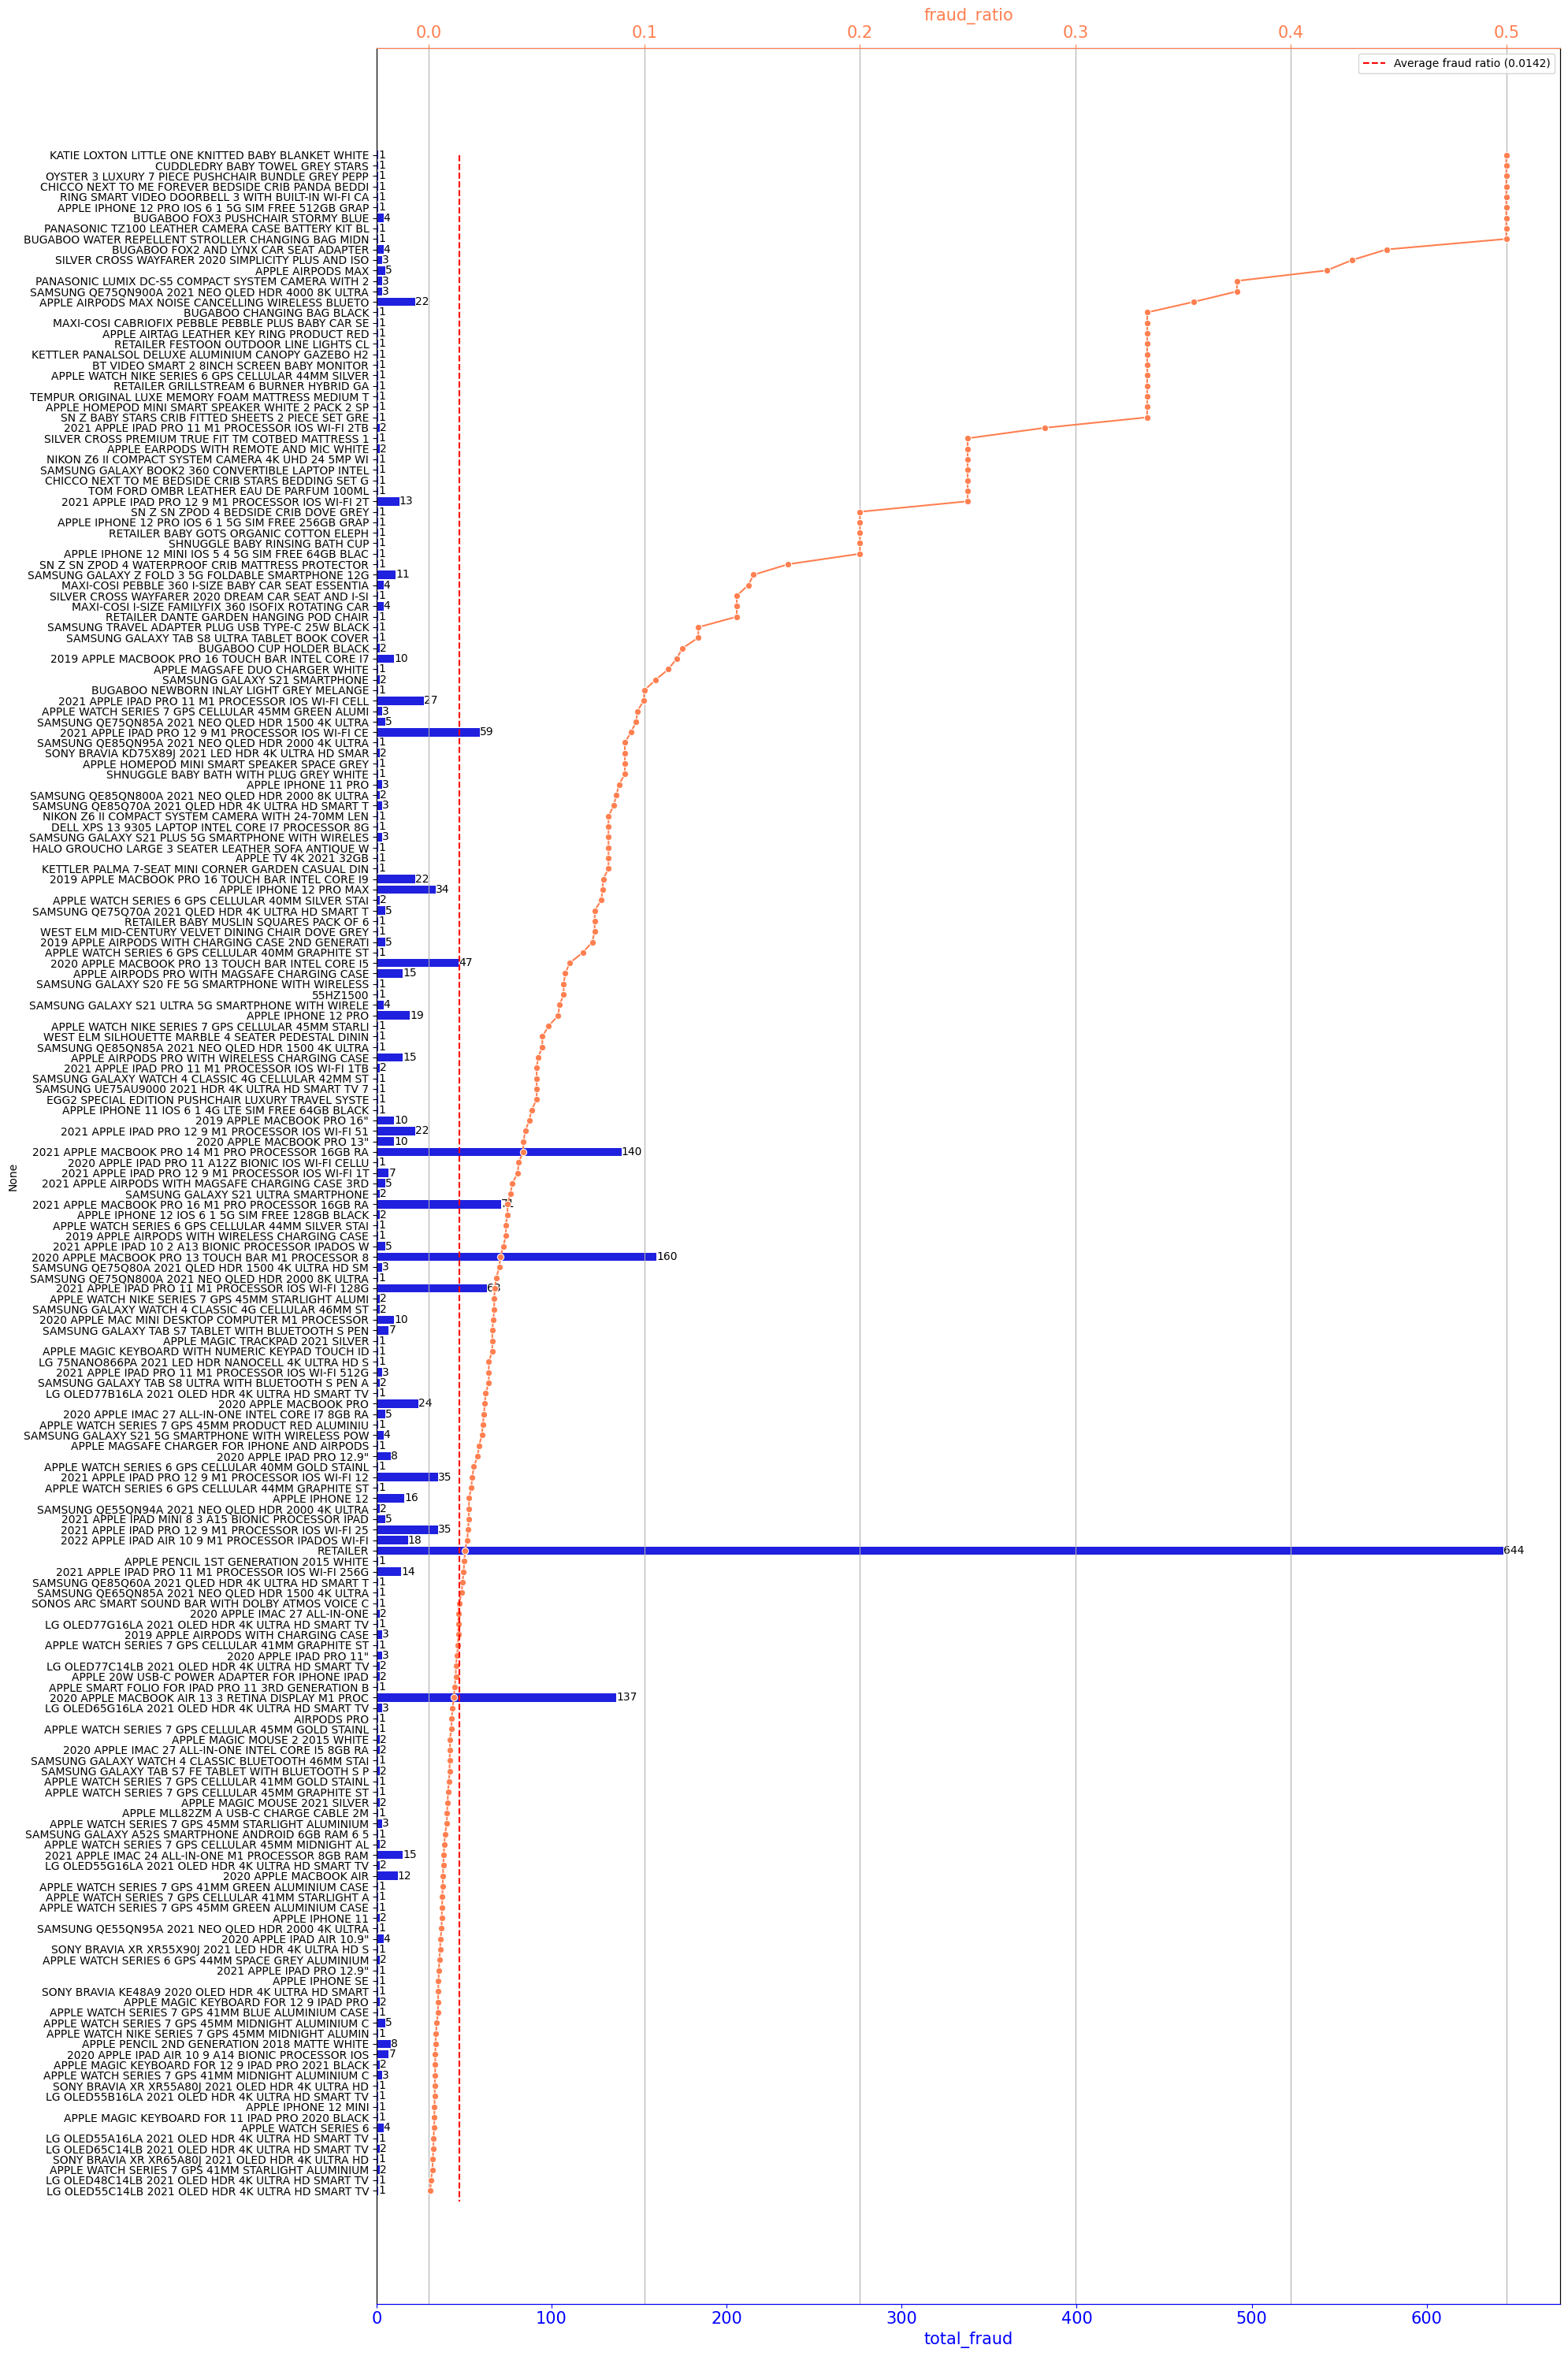

In [40]:
plot_fraud_ratio(df, column="model", figsize=(20, 30))

We see that MacBook pro are actually quite average in terms of fraud ratio, compared to e.g. AirPods Pro. Some Airpods Pro models are subject to fraud more than 30% of the time!